In [1]:
#Analyse af dividend aktier
#Historisk analyse af prisudvikling før og efter offentl af regnskab, samt andre milepæle (eks ex-dividend dato), 
#sammenholdt med dividend % samt frekvens

#Regression analyse af effekt af ex-dividend dato på aktiekurs DONE

#Null-hypotese: ex-dividend kursstigning udlignes med tilsvarende kursfald
#Alternativ hypotese: Kurs er forskellig fra ex-dividend kursstigning  

#Delanalyser: Segmenter på dividend-gains, frekvens etc.    
#Explore whether to include trade volumen in analysis: STIGER VOLUMEN UMIDDELB FØR/EFTER EXDIV0??
#Descriptive analysis; various plots

#teste pris 1/2 uger før ex-div + 1-2 dage efter ex-div DONE
#teste strategi versus buy&hold DONE (eksl taxes)

#Are the deltas statistically significant???

#Tableau?

#SVARER FALD TIL DIVIDEND PAYOUT? HVIS NEJ, HVAD ER DELTA OG ER DET MERE ELLER MINDRE END DIVIDEND?

#Metodiske bemærkninger og afgrænsning: 
#DA-liste fra 2023, data frem til ultimo 2023
#Time period: 2001 - 2023
#portfolio defined by dataset: X no of stocks CHECK SOURCE IF INFO ON TYPES OF STOCKS ETC
#use adjusted close

#Har declaration date indflydelse? Hvornår er den typisk? Husk at bemærke, at "cash flow" er forsinket for udbytter

#Lav spider chart med de 5 risikoparametre

#Brug chatgpt til at teste strategi!!!!! 

# EVALUERING AF DCS !!!!!!!!!!!!!!!!! > DCS på hver enkelt aktie NOT POSSIBLE

# HUSK DIVIDEND !!!!!!!!!!!!!!!!!!!!! DONE

# INCORPORATE FORECASTS ?!?!?!?!? Not possible

# MODEL BEST PORTFOLIO BASED SORTINO RATIO FOR 4 STOCKS: DONE

# P-VALUES FOR THE BEST PERFORMING STOCKS (FAMA): relevant? 

# beta, sharpe and sortino for alle strategier DONE

# CHANGE TO MONTHLY ?!?!?!?!

# ARE FF RATIOS BEFORE OR AFTER TAX? before 

# Drawdown analysis

#LAVE EN SUPPLERENDE ANALYSE HVOR DE 10 FØRSTE DAGE OG DE 10 SIDSTE DAGE ANALYSERES
#UDVIDE DATA MED FLERE AKTIER OG/ELLER LÆNGERE TIDSSERIE

### Executive Summary

Present analysis assesses the risk-adjusted profitability of a Dividend Capture Strategy (DCS) of trading 2 pairs of 2 so-called "Dividend Aristocrats" stocks, measuring the performance against alternative strategies.

The analysis indicates that a DCS strategy could prove highly profitable, albeit with a higher risk exposure compared to a strategy based on SP 500 or Nasdaq index investing. 

In addition, the analysis shows that volatility and drawdowns are not in sync with SP 500 nor NASDAQ thus providing a potential hedging alternative to investors wanting to interested in having a more spread out risk profile in the investment portfolio.

BUT IF REGR ANALYSIS SHOWS THAT THERE IS EQUAL CHANCE THAT DELTA IS ABOVE AS BELOW THEN RESULT IS JUST COINCIDENCE...OR ?!?!?!?! MAKE REGR ANALYSIS ON SELECTED STOCKS

IF STOCKS ARE INCREASING OVER TIME ALL OTHER THINGS EQUAL IT SHOULD BE REFLECTED IN THE REGR ANALYSIS !!!!!!!!!!!!!!!!


### Table of Contents

* [Goals](#goals)
* [Methodology and Delimitations](#methodology_and_delimitations)
* [Data](#Data)
    * [Loading the Data](#section1_1)
    * [Data Information](#section1_2)
* [Data Cleaning](#cleaning)
    * [Adding an Age Column](#section2_1)
    * [Checking the Education Variable](#section2_2)
* [Exploratory Data Analysis](#EDA)
    * [Big Picture](#section3_1)
    * [Purchasing Behavior by Income](#section3_2)
    * [More Purchasing Behavior by Income](#section3_3)
    * [Purchasing Behavior by Education and Income](#section3_4)
    * [Purchasing Behavior by Age](#section3_5)
* [Conclusion](#conclusion)

### Goals <a class="anchor" id="Goals"></a>

This notebook combines pulling data from Yahoo Finance (yfinance) and a list of 2023 Dividend Aristocrats. The goal for this project is to:
* Load the data
* Clean the data to remove missing information and errors that may cause issues later on
* Transform the data so it is ready for analysis
* Assess DCS
* Compare DCS with alternative strategies including index investing (SP 500 and Nasdaq) and buy & hold dividend stock investing 

### Methodology and Delimitations <a class="anchor" id="Goals"></a>

The analysis is based on a time range from 1998 to 2023. Only dividend stocks that are active in the entire range are included.

Tax is included. Specifically, Danish tax conditions are applied. However, in case of negative profitability the tax discount is not carried out to the subsequent year as current law allows. This is a potential improvement point.

The dividend stocks selected are based on the 2023 list of "Dividend Aristocrats" from www.suredividend.com.

The evaluation of DCS is limited to trading 2 pairs of 2 stocks. This is based on the assumption that the potential target segment for the strategy is an active investor who has limited time and resources to manage her investments. In this regard, carrying out ~4 trades per quarter of the same 4 stocks seems reasonable.




In [2]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import yfinance as yf
from datetime import timedelta
import statsmodels.api as sm

C:\Users\jonat\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# LOAD DIVIDEND ARISTOCRATS LIST

# Load csv file
da_raw = pd.read_csv("dividend_aristocrats 03.10.23.csv")

# Rename column
da_raw = da_raw.rename(columns = {"Ticker": "symbol"})

# Remove irrelevant columns
remove = ["Years of Dividend Increases","1-Year Dividend Growth","5-Year Dividend Growth (Annualized)",
          "Dividends Per Share (TTM)","Market Cap ($M)","Trailing P/E Ratio","Payout Ratio","Beta",
          "52-Week High","52-Week Low", "Dividend Yield","Name","Price","Sector","Price"]
da_raw = da_raw[da_raw.columns.difference(remove)]

# List of companies to drop because data is incomplete for the time period applied
lst = ["ATO", "CB", "CTAS", "MCD", "SPGI", "EXPD", "ABBV", "LIN", "AMCR", "BF.B"]

# Create a boolean mask where True indicates rows to keep
mask = ~da_raw['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
da = da_raw[mask]

# Convert to list
da_lst = da["symbol"].tolist()

#print(da)

In [4]:
# LOAD HISTORICAL DATA OF THE DIVIDEND STOCKS FROM YFINANCE

# List of SP 500 and NASDAQ symbols
indices = ['^GSPC', '^IXIC', 'IVV', 'QQQ']

# Add SP 500 and NASDAQ to the list of Dividend Aristocrats
stocks = da_lst + indices 
#print(stocks)

# Define date range
start_date = '2001-01-01'
end_date = '2024-01-01'

start_year = start_date.dt.year  
print(start_year)

# Create an empty DataFrame to store historical price, dividend, closing price, and adjusted closing price data
all_data = pd.DataFrame()

# Loop through each stock symbol and download data from yfinance
for stock in stocks:
    
    # Download historical price and dividend data for the stock
    stock_data = yf.download(stock, start=start_date, end=end_date).reset_index()
    dividend_data = yf.Ticker(stock).dividends.reset_index()
    
    # Ensure date format is correct
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data['Date'] = stock_data['Date'].dt.date
    dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
    dividend_data['Date'] = dividend_data['Date'].dt.date
    
    # Merge historical price data with dividend data on date
    merged_data = pd.merge(stock_data, dividend_data, how = 'left', on = 'Date')
    
    # Add a column to identify the stock
    merged_data['Symbol'] = stock
    
    # Concatenate the data to the DataFrame
    all_data = pd.concat([all_data, merged_data])

# Save the data to a CSV file
all_data.to_csv('historical_prices_with_dividends.csv', index = False)
all_data = pd.read_csv("historical_prices_with_dividends.csv")

#print(all_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [414]:
# DATA PREPARATION 1/2

# Create object for start year
start_date = pd.to_datetime(start_date)
start_year = start_date.year  

# Create object for end year
end_date = pd.to_datetime(end_date)
end_year = end_date.year  

# Rename and remove columns
all_data = all_data.rename(columns = {
    "Symbol": "symbol", "Date": "date", "Dividends": "dividend", "Adj Close": "close_adjusted"})
remove = ["Open", "High", "Low", "Close", "Volume"]
all_data_cleaned = all_data[all_data.columns.difference(remove)]

#print(all_data_cleaned)

In [6]:
# DATA PREPARATION 2/2

# Create df that is to contain dates halfway between the ex-dividend dates  
dd_raw = all_data_cleaned
dd_raw = dd_raw.sort_values(by = ["symbol", "date"])

dd_halfway = dd_raw

# Convert the "date" column to datetime
dd_halfway['date'] = pd.to_datetime(dd_halfway['date'])

# Sort the DataFrame by "symbol" and then "date"
dd_halfway = dd_halfway.sort_values(by = ["symbol", "date"])

# Function to find the nearest weekday
def nearest_weekday(dt):
    if dt.weekday() >= 5:  # If Saturday or Sunday, move to Monday
        return dt + timedelta(days = (7 - dt.weekday()) % 5)
    else:
        return dt

# Calculate the halfway date
dd_halfway['halfway_date'] = dd_halfway['date'].shift(1) + (dd_halfway['date'] - dd_halfway['date'].shift(1)) / 2
dd_halfway['halfway_date'] = dd_halfway['halfway_date'].apply(nearest_weekday)

# convert date columns to string
dd_halfway["date"] = dd_halfway["date"].astype(str)
dd_halfway["halfway_date"] = dd_halfway["halfway_date"].astype(str)

# Create new df "halfway_date", drop and rename date columns
halfway_date = dd_halfway
halfway_date = halfway_date.drop(["dividend", "date"], axis = 1)
halfway_date = halfway_date.rename(columns = {"halfway_date": "date"})

# Convert the date column to datetime type
halfway_date['date'] = pd.to_datetime(halfway_date['date'])

# Remove the time component
halfway_date['date'] = halfway_date['date'].dt.date
halfway_date['date'] = pd.to_datetime(halfway_date['date'])

#print(halfway_date)

In [259]:
# DCS SELECTED HALFWAY: Performance Analysis

import exchange_calendars as xcals
from datetime import time
import pandas_market_calendars as mcal
from pandas_market_calendars import get_calendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import timedelta

# Sort values to ensure correct reading of data prior to analysis
sp_dd_da_merged = all_data_cleaned.sort_values(['symbol', 'date'], ascending = [True, True]).reset_index(drop = True)

# Create copy of df to be used later
sp_dd_da_merged_selected = sp_dd_da_merged

# Create copy of df to be used later
ff = sp_dd_da_merged 

# Function to loop through the 2 pairs of dividend stocks to calculate the profitability 
def dcs_avg_das(lst_1, lst_2, tax_rate):

    # Set sp_dd_da_merged to global to ensure usability outside function
    global sp_dd_da_merged 
    
    # Create dfs for each pair of stocks 
    sp_dd_da_merged_1 = sp_dd_da_merged[sp_dd_da_merged["symbol"].isin(lst_1)] 
    sp_dd_da_merged_2 = sp_dd_da_merged[sp_dd_da_merged["symbol"].isin(lst_2)]

    # Sort dfs by date 
    sp_dd_da_merged_1 = sp_dd_da_merged_1.sort_values(['date'], ascending = [True]).reset_index(drop = True)
    sp_dd_da_merged_2 = sp_dd_da_merged_2.sort_values(['date'], ascending = [True]).reset_index(drop = True)

    # Create new column "key" to act as key to connect data later on
    sp_dd_da_merged_1["key"] = sp_dd_da_merged_1["date"] + sp_dd_da_merged_1["symbol"]
    sp_dd_da_merged_2["key"] = sp_dd_da_merged_2["date"] + sp_dd_da_merged_2["symbol"]

    # Create new dfs that are to contain only ex-dividend dates 
    sp_dd_da_onlydd_1 = sp_dd_da_merged_1
    sp_dd_da_onlydd_2 = sp_dd_da_merged_2

    # Ensure date columns are in datetime format
    sp_dd_da_onlydd_1['date'] = pd.to_datetime(sp_dd_da_onlydd_1['date'])
    sp_dd_da_onlydd_2['date'] = pd.to_datetime(sp_dd_da_onlydd_2['date'])

    # Filter the df to only have ex-dividend dates
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.loc[(sp_dd_da_onlydd_1["dividend"] > 0)]
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.loc[(sp_dd_da_onlydd_2["dividend"] > 0)]

    # Reset indices
    sp_dd_da_onlydd_1.reset_index(inplace = True, drop = True)
    sp_dd_da_onlydd_2.reset_index(inplace = True, drop = True)

#-------------------------------------------------------------------------------------------- 

# Function to find the nearest weekday
    def nearest_weekday(dt):
        if dt.weekday() >= 5:  # If Saturday or Sunday, move to Monday
            return dt + timedelta(days = (7 - dt.weekday()) % 5)
        else:
            return dt

    # Create copies to keep the origninal df unchanged 
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.copy()
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.copy()
    
    # Calculate the halfway date
    sp_dd_da_onlydd_1 = sp_dd_da_onlydd_1.copy()
    sp_dd_da_onlydd_2 = sp_dd_da_onlydd_2.copy()

    # Calculate the halfway date
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['date'].shift(1) + (
        sp_dd_da_onlydd_1['date'] - sp_dd_da_onlydd_1['date'].shift(1)) / 2
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['date'].shift(1) + (
        sp_dd_da_onlydd_2['date'] - sp_dd_da_onlydd_2['date'].shift(1)) / 2

    # Apply function "nearest_weekday" to ensure halfway dates are weekdays
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['halfway_date'].apply(nearest_weekday)
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['halfway_date'].apply(nearest_weekday)

    # Remove the time component
    sp_dd_da_onlydd_1['halfway_date'] = sp_dd_da_onlydd_1['halfway_date'].dt.date
    sp_dd_da_onlydd_2['halfway_date'] = sp_dd_da_onlydd_2['halfway_date'].dt.date

    # Convert to datetime format
    sp_dd_da_onlydd_1['halfway_date'] = pd.to_datetime(sp_dd_da_onlydd_1['halfway_date'])
    sp_dd_da_onlydd_2['halfway_date'] = pd.to_datetime(sp_dd_da_onlydd_2['halfway_date'])

#--------------------------------------------------------------------------------------------

    # Function to ensure dates halfway between ex-dividend dates are on open business days (US calendar)    
    def yours_1(sp_dd_da_onlydd_1):
        
        # Load US calendar with holidys and business days
        nyse = mcal.get_calendar('NYSE')
        holidays = nyse.holidays()
        holidays = list(holidays.holidays)
        
        # Create object that contains only the business days
        US_BUSINESS_DAY = CustomBusinessDay(holidays = holidays)

        # Create object that is a copy of the 
        #result_1 = sp_dd_da_onlydd_1['date'].copy()
        result_1 = sp_dd_da_onlydd_1['halfway_date'].copy()

        #for i, date in enumerate(sp_dd_da_onlydd_1['date']):
        for i, date in enumerate(sp_dd_da_onlydd_1['halfway_date']):
            if date in holidays:
                result_1.iloc[i] = date - 1 * US_BUSINESS_DAY

        sp_dd_da_onlydd_1['adjusted_date'] = result_1

        return sp_dd_da_onlydd_1

    # Function to ensure dates halfway between ex-dividend dates are on open business days (US calendar)    
    def yours_2(sp_dd_da_onlydd_2):
        nyse = mcal.get_calendar('NYSE')
        holidays = nyse.holidays()
        holidays = list(holidays.holidays)
        US_BUSINESS_DAY = CustomBusinessDay(holidays = holidays)

        #result_2 = sp_dd_da_onlydd_2['date'].copy()
        result_2 = sp_dd_da_onlydd_2['halfway_date'].copy()

        #for i, date in enumerate(sp_dd_da_onlydd_2['date']):
        for i, date in enumerate(sp_dd_da_onlydd_2['halfway_date']):
            if date in holidays:
                result_2.iloc[i] = date - 1 * US_BUSINESS_DAY

        sp_dd_da_onlydd_2['adjusted_date'] = result_2

        return sp_dd_da_onlydd_2

    # Apply function above and create a copy to keep the original DataFrame unchanged
    result_df_1 = yours_1(sp_dd_da_onlydd_1.copy())
    result_df_2 = yours_2(sp_dd_da_onlydd_2.copy()) 

    # Duplicate above dfs for later use
    halfway_dates_1 = result_df_1
    halfway_dates_2 = result_df_2

    only_dd_1 = result_df_1
    only_dd_2 = result_df_2

    # Convert date columns to string to be able to create key below
    halfway_dates_1["adjusted_date"] = halfway_dates_1["adjusted_date"].astype(str)
    halfway_dates_2["adjusted_date"] = halfway_dates_2["adjusted_date"].astype(str)

    # Create new column that contains key
    halfway_dates_1["key"] = halfway_dates_1["adjusted_date"] + halfway_dates_1["symbol"]
    halfway_dates_2["key"] = halfway_dates_2["adjusted_date"] + halfway_dates_2["symbol"]

    # Remove unnecessary columns
    halfway_dates_1 = halfway_dates_1.drop(["close_adjusted", "dividend"], axis = 1)
    halfway_dates_2 = halfway_dates_2.drop(["close_adjusted", "dividend"], axis = 1)

    # Merge halfway_dates with sp_dd_da_merged so that prices, dividend and dividend dates, 
    # as well as halfway dates og prices priser are included

    # Convert date columns to string to be able to create key below
    result_df_1["adjusted_date"] = result_df_1["adjusted_date"].astype(str)
    result_df_2["adjusted_date"] = result_df_2["adjusted_date"].astype(str)

    # Create new column that contains key
    result_df_1["key"] = result_df_1["adjusted_date"] + result_df_1["symbol"]
    result_df_2["key"] = result_df_2["adjusted_date"] + result_df_2["symbol"]

    # Create new column that contains key
    only_dd_1["key"] = only_dd_1["adjusted_date"] + only_dd_1["symbol"]
    only_dd_2["key"] = only_dd_2["adjusted_date"] + only_dd_2["symbol"]

    # Remove price column
    only_dd_1 = only_dd_1.drop(["close_adjusted"], axis = 1)
    only_dd_2 = only_dd_2.drop(["close_adjusted"], axis = 1)

    # Ensure that NaN values are removed to avoid issues
    only_dd_1 = only_dd_1.dropna()
    only_dd_2 = only_dd_2.dropna()

    # Remove dividend columns
    result_df_1 = result_df_1.drop(["dividend"], axis = 1)
    result_df_2 = result_df_2.drop(["dividend"], axis = 1)

    # Merge "halfway_dates" and "sp_dd_da_merged"
    
    # Merge df containing dividends with df that contains halfway dates
    halfway_date_onlydd_prices_1 = pd.merge(halfway_dates_1, sp_dd_da_merged_1, how = "left", on = ["key"])
    halfway_date_onlydd_prices_2 = pd.merge(halfway_dates_2, sp_dd_da_merged_2, how = "left", on = ["key"])

    # Merge above df with df that only contains dividend dates
    halfway_date_onlydd_prices_final_1 = pd.merge(halfway_date_onlydd_prices_1, only_dd_1, how = "outer", on = ["key"])
    halfway_date_onlydd_prices_final_2 = pd.merge(halfway_date_onlydd_prices_2, only_dd_2, how = "outer", on = ["key"])

    # Remove columns
    halfway_date_onlydd_prices_final_1 = halfway_date_onlydd_prices_final_1.drop(
        columns = ["date_y", "dividend_x", "symbol_y", "date", "symbol_x", "halfway_date_y", "adjusted_date_y"])
    halfway_date_onlydd_prices_final_2 = halfway_date_onlydd_prices_final_2.drop(
        columns = ["date_y", "dividend_x", "symbol_y", "date", "symbol_x", "halfway_date_y", "adjusted_date_y"])

    # Create new df and convert to datetime
    halfway_stock_lst_1 = halfway_date_onlydd_prices_final_1
    halfway_stock_lst_1["halfway_date_x"] = pd.to_datetime(halfway_stock_lst_1['halfway_date_x'])
    
    # Create new df and convert to datetime
    halfway_stock_lst_2 = halfway_date_onlydd_prices_final_2
    halfway_stock_lst_2["halfway_date_x"] = pd.to_datetime(halfway_stock_lst_2['halfway_date_x'])
    
    # Create new dfs
    sp_dd_da_merged_lst_1 = sp_dd_da_merged
    sp_dd_da_merged_lst_2 = sp_dd_da_merged
    
    # Rename column
    sp_dd_da_merged = sp_dd_da_merged.rename(columns = {"date": "adjusted_date_x"})
    
    

    # LIST 1 
    
    #1 Get symbols from list and rename
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1[sp_dd_da_merged_lst_1["symbol"] == lst_1[0]]
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1_0.rename(columns = {"date": "halfway_date_x"})
    
    #2 Get symbols from list and rename
    sp_dd_da_merged_lst_1_1 = sp_dd_da_merged_lst_1[sp_dd_da_merged_lst_1["symbol"] == lst_1[1]]
    sp_dd_da_merged_lst_1_1 = sp_dd_da_merged_lst_1_1.rename(columns = {"date": "halfway_date_x"})
    
    #3 Convert to datetime
    sp_dd_da_merged_lst_1_0["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_1_0['halfway_date_x'])    
    sp_dd_da_merged_lst_1_1["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_1_1['halfway_date_x'])
    
    #4 Merge dfs on date
    merged_lst_1 = pd.merge(sp_dd_da_merged_lst_1_1, halfway_stock_lst_1, how = "right", on = ["halfway_date_x"])
    
    #5 Drop dividend column
    sp_dd_da_merged_lst_1_0 = sp_dd_da_merged_lst_1_0.drop(["dividend"], axis = 1)
    
    #6 Merge dfs on date
    merged_lst_1 = pd.merge(sp_dd_da_merged_lst_1_0, merged_lst_1, how = "right", on = ["halfway_date_x"])
    #print(merged_lst_1)
    
    #7 Drop unnecessary columns
    #merged_lst_2 = merged_lst_2.drop(columns = ["halfway_date_x", "symbol", "symbol_x", "key", "symbol_y"])
    merged_lst_1 = merged_lst_1.drop(columns = ["halfway_date_x", "symbol", "symbol_x", "key"])
    #print(merged_lst_1)
    
    #8 Function to create new column based on conditions
    def create_new_column(row):
        if row.name % 2 == 0:  # Even index
            return row['close_adjusted']
        else:  # Odd index
            return row['close_adjusted_x']

    #9 Apply above function 
    merged_lst_1['close_adjusted_z'] = merged_lst_1.apply(create_new_column, axis = 1)

    #10 Convert to dateime
    merged_lst_1["adjusted_date_x"] = pd.to_datetime(merged_lst_1["adjusted_date_x"])

    #11 Drop the last row as it will have NaN in the 'diff' column
    merged_lst_1 = merged_lst_1[:-1]
 
    # Calculate the dividend incl tax
    #merged_lst_1["dividend_y"] = merged_lst_1["dividend_y"] * (1 - tax_rate)
    
    #12 Calculate dollar return
    merged_lst_1['diff'] = merged_lst_1['close_adjusted_z'].shift(-1) + merged_lst_1[
        "dividend_y"] - merged_lst_1['close_adjusted_y'] 
    #print(merged_lst_1)
    
    #13
    # Calculcate the percentual difference
    merged_lst_1["diff_perc"] = merged_lst_1['diff'] / merged_lst_1['close_adjusted_y'] 
    
    merged_lst_1 = merged_lst_1.drop(columns = ["symbol_y"])
    #print(merged_lst_1)
    
    #14 Group by year and sum columns
    #
    #grouped_df = trades_df.groupby(trades_df['sell_date'].dt.year).agg(profit=(
    #'profit', 'sum'), dividend_after_tax=('dividend_after_tax', 'sum')).reset_index()
    
    merged_lst_1 = merged_lst_1.groupby(merged_lst_1['date_x'].dt.year).agg(diff = (
        "diff", "sum"), dividend_y = ("dividend_y", "sum"), diff_perc = ("diff_perc", "sum")).reset_index()
    #merged_lst_1 = merged_lst_1.groupby(merged_lst_1['adjusted_date_x'].dt.year).agg(diff = ("diff", "sum")).reset_index()
    print(merged_lst_1)
    
    #15 Calculate tax for trades only
    #tax = []
#    for i in merged_lst_1['diff']:
 #       if i == merged_lst_1['diff'][0]:
  #          tax.append(i)
   #     elif i <= 0:
    #        tax.append(i)
     #   else:
      #      tax.append(i * (1 - tax_rate))
    
    #tax_df = pd.DataFrame(tax)
    #tax_df = tax_df.rename(columns = {0: "diff_inc_tax"})
    #print(tax_df)
    
    #16 Merge trades with tax
    #merged_lst_1 = pd.merge(merged_lst_1, how = "inner", left_index = True, right_index = True)
    #merged_lst_1 = pd.merge(merged_lst_1, tax_df, how = "inner", left_index = True, right_index = True)
    #print(merged_lst_1)
    
    #merged_lst_1['diff'] = merged_lst_1['diff'] + merged_lst_1['dividend_y']
    #merged_lst_1['diff_inc_tax'] = merged_lst_1['diff_inc_tax'] + merged_lst_1['dividend_y']

    #merged_lst_1["diff_perc_inc_tax"] = merged_lst_1['diff_inc_tax'] / merged_lst_1['close_adjusted_y'] 
    #print(merged_lst_1)
    
    # Convert to annual aggregating respective columns
#    merged_lst_1 = merged_lst_1.groupby(merged_lst_1['date_x'].dt.year).agg(
 #       diff_inc_tax = ('diff_inc_tax', 'sum'), dividend_y = ('dividend_y', 'sum'), diff_perc_inc_tax = (
  #          'diff_perc_inc_tax', 'mean')).reset_index()  
    
    #merged_lst_1 = merged_lst_1.groupby(merged_lst_1['date_x']).agg(dividend_y = (
     #   'dividend_y', 'sum'), diff_perc = ('diff_perc', 'mean'), diff = ('diff', 'sum')).reset_index()  

    # Rename columns        
    merged_lst_1 = merged_lst_1.rename(columns = {"date_x": "year"})
    #print(merged_lst_1)
    
    #17
    #merged_lst_1 = merged_lst_1.rename(columns = {merged_lst_1.columns[2]: "diff_inc_tax"}, inplace = False)
    
    #trades_df["profits_and_dividends"] = trades_df["profit_trades_after_tax"] + trades_df["dividend_after_tax"]
    #merged_lst_1["total_diff_inc_tax"] = merged_lst_1["diff_inc_tax"] + merged_lst_1["dividend_y"] 
    #print(merged_lst_2)
    
    # Step 2: Normalize the values so that the values for 1998 become 100
    
    #18 Calculate accumulated difference
    merged_lst_1["diff_acc"] = merged_lst_1["diff"].cumsum()
    #merged_lst_1["diff_acc"] = merged_lst_1["total_diff_inc_tax"].cumsum()
    merged_lst_1["diff_acc_perc"] = merged_lst_1["diff_perc"].cumsum()
    #merged_lst_1["diff_acc_perc"] = merged_lst_1["diff_perc_inc_tax"].cumsum()

    #19 Normalize first year to 100
    merged_lst_1['normalized_diff_acc'] = merged_lst_1["diff_acc"] / merged_lst_1["diff_acc"].iloc[0] * 100
    merged_lst_1['normalized_diff_acc_perc'] = merged_lst_1["diff_acc_perc"] / merged_lst_1["diff_acc_perc"].iloc[0] * 100
    #print(merged_lst_1)
    
    
    
    
    # LIST 2

    #1 Get symbols from list and rename
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2[sp_dd_da_merged_lst_2["symbol"] == lst_2[0]]
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2_0.rename(columns = {"date": "halfway_date_x"})
    
    #2 Get symbols from list and rename
    sp_dd_da_merged_lst_2_1 = sp_dd_da_merged_lst_2[sp_dd_da_merged_lst_2["symbol"] == lst_2[1]]
    sp_dd_da_merged_lst_2_1 = sp_dd_da_merged_lst_2_1.rename(columns = {"date": "halfway_date_x"})
    
    #3 Convert to datetime
    sp_dd_da_merged_lst_2_0["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_2_0['halfway_date_x'])    
    sp_dd_da_merged_lst_2_1["halfway_date_x"] = pd.to_datetime(sp_dd_da_merged_lst_2_1['halfway_date_x'])
    
    #4 Merge dfs on date
    merged_lst_2 = pd.merge(sp_dd_da_merged_lst_2_1, halfway_stock_lst_2, how = "right", on = ["halfway_date_x"])
    
    #5 Drop column
    sp_dd_da_merged_lst_2_0 = sp_dd_da_merged_lst_2_0.drop(["dividend"], axis = 1)
    
    #6 Merge dfs
    merged_lst_2 = pd.merge(sp_dd_da_merged_lst_2_0, merged_lst_2, how = "right", on = ["halfway_date_x"])
    #print(merged_lst_2)
    
    #7 Drop unnecessary columns
    #merged_lst_2 = merged_lst_2.drop(columns = ["halfway_date_x", "symbol", "symbol_x", "key", "symbol_y"])
    merged_lst_2 = merged_lst_2.drop(columns = ["halfway_date_x", "symbol", "symbol_x", "key"])
    
    #8 Function to create new column based on conditions
    def create_new_column(row):
        if row.name % 2 == 0:  # Even index
            return row['close_adjusted']
        else:  # Odd index
            return row['close_adjusted_x']

    #9 Apply above function
    merged_lst_2['close_adjusted_z'] = merged_lst_2.apply(create_new_column, axis = 1)

    #10 Convert to datetime
    merged_lst_2["adjusted_date_x"] = pd.to_datetime(merged_lst_2["adjusted_date_x"])

    #11 Drop the last row as it will have NaN in the 'diff' column
    merged_lst_2 = merged_lst_2[:-1]
 
    # Calculate the dividend incl tax
    #merged_lst_2["dividend_y"] = merged_lst_2["dividend_y"] * (1 - tax_rate)
    
    #12 Calculate dollar return
    merged_lst_2['diff'] = merged_lst_2['close_adjusted_z'].shift(-1) + merged_lst_2[
        "dividend_y"] - merged_lst_2['close_adjusted_y'] 
    #print(merged_lst_2)
    
    #13 Calculcate the percentual difference 
    merged_lst_2["diff_perc"] = merged_lst_2['diff'] / merged_lst_2['close_adjusted_y'] 
    
    merged_lst_2 = merged_lst_2.drop(columns = ["symbol_y"])
    #print(merged_lst_2)
    
    #14 Group by year and sum columns
    #
    #grouped_df = trades_df.groupby(trades_df['sell_date'].dt.year).agg(profit=(
    #'profit', 'sum'), dividend_after_tax=('dividend_after_tax', 'sum')).reset_index()
    
    merged_lst_2 = merged_lst_2.groupby(merged_lst_2['date_x'].dt.year).agg(diff = (
        "diff", "sum"), dividend_y = ("dividend_y", "sum"), diff_perc = ("diff_perc", "sum")).reset_index()
    #merged_lst_2 = merged_lst_2.groupby(merged_lst_2['adjusted_date_x'].dt.year).agg(diff = ("diff", "sum")).reset_index()
    #print(merged_lst_2)
    
    #15 Calculate tax for trades only
    #tax = []
#    for i in merged_lst_2['diff']:
 #       if i == merged_lst_2['diff'][0]:
  #          tax.append(i)
   #     elif i <= 0:
    #        tax.append(i)
     #   else:
      #      tax.append(i * (1 - tax_rate))
    
    #tax_df = pd.DataFrame(tax)
    #tax_df = tax_df.rename(columns = {0: "diff_inc_tax"})
    #print(tax_df)
    
    #16 Merge trades with tax
    #merged_lst_2 = pd.merge(merged_lst_2, how = "inner", left_index = True, right_index = True)
    #merged_lst_2 = pd.merge(merged_lst_2, tax_df, how = "inner", left_index = True, right_index = True)
    #print(merged_lst_2)
    
    #merged_lst_2['diff'] = merged_lst_2['diff'] + merged_lst_2['dividend_y']
    #merged_lst_2['diff_inc_tax'] = merged_lst_2['diff_inc_tax'] + merged_lst_2['dividend_y']

    #merged_lst_2["diff_perc_inc_tax"] = merged_lst_2['diff_inc_tax'] / merged_lst_2['close_adjusted_y'] 
    #print(merged_lst_2)
    
    # Convert to annual aggregating respective columns
#    merged_lst_2 = merged_lst_2.groupby(merged_lst_2['date_x'].dt.year).agg(
 #       diff_inc_tax = ('diff_inc_tax', 'sum'), dividend_y = ('dividend_y', 'sum'), diff_perc_inc_tax = (
  #          'diff_perc_inc_tax', 'mean')).reset_index()  
    
    #merged_lst_2 = merged_lst_2.groupby(merged_lst_2['date_x']).agg(dividend_y = (
     #   'dividend_y', 'sum'), diff_perc = ('diff_perc', 'mean'), diff = ('diff', 'sum')).reset_index()  

    # Rename columns
    merged_lst_2 = merged_lst_2.rename(columns = {"date_x": "year"})
    #print(merged_lst_2)
    
    #17
    #merged_lst_2 = merged_lst_2.rename(columns = {merged_lst_2.columns[2]: "diff_inc_tax"}, inplace = False)
    
    #trades_df["profits_and_dividends"] = trades_df["profit_trades_after_tax"] + trades_df["dividend_after_tax"]
    #merged_lst_2["total_diff_inc_tax"] = merged_lst_2["diff_inc_tax"] + merged_lst_2["dividend_y"] 
    #print(merged_lst_2)
    
    # Step 2: Normalize the values so that the values for 1998 become 100
    
    #18 Calculate accumulated difference
    merged_lst_2["diff_acc"] = merged_lst_2["diff"].cumsum()
    #merged_lst_2["diff_acc"] = merged_lst_2["total_diff_inc_tax"].cumsum()
    merged_lst_2["diff_acc_perc"] = merged_lst_2["diff_perc"].cumsum()
    #merged_lst_2["diff_acc_perc"] = merged_lst_2["diff_perc_inc_tax"].cumsum()

    #19 Normalize first year to 100
    merged_lst_2['normalized_diff_acc'] = merged_lst_2["diff_acc"] / merged_lst_2["diff_acc"].iloc[0] * 100
    merged_lst_2['normalized_diff_acc_perc'] = merged_lst_2["diff_acc_perc"] / merged_lst_2["diff_acc_perc"].iloc[0] * 100
    #print(merged_lst_2)

    
   
    # MERGE THE DATAFRAMES AND CALCULATE AVERAGE
    
    # Merge dataframes
    pairwise_avgs = pd.merge(merged_lst_1, merged_lst_2, how = "inner", on = ["year"])
    #print(pairwise_avgs)
    
    # Calculate mean accumulated difference across both pair of stocks
    pairwise_avgs["avg"] = (merged_lst_1["normalized_diff_acc"] + merged_lst_2["normalized_diff_acc"]) / 2
    
    #pairwise_avgs["avg_perc"] = (merged_lst_1["normalized_diff_acc_perc"] + merged_lst_2["normalized_diff_acc_perc"]) / 2 
    
    return pairwise_avgs


lst_1 = ["FRT","CVX"]
lst_2 = ["ESS","MMM"]

#tax_rate = 0.27
#tax_rate_bh = 0.42

#"I 2024 er satsen på gevinst af aktier henholdsvis 27% af gevinster under 61.000 kr. og 42% af gevinster over 61.000 kr. 
#Det er ikke en sammenlagt skat, så du bliver beskattet pr. aktie du sælger. 
#Så du bliver beskattet 27% hvis du sælger flere aktier under 61.000  kr selvom de tilsammen giver en gevinst 
#der er større end 61.000 kr."

final = dcs_avg_das(lst_1, lst_2)
#final = dcs_avg_das(lst_1, lst_2, tax_rate)
#final = dcs_avg_das(lst_1, lst_1, tax_rate)

#final["halfway_perf"] = (final["diff_inc_tax_x"] + final["diff_inc_tax_y"]) / 2
final["diff_perc"] = (final["diff_perc_x"] + final["diff_perc_y"]) / 2

#final = final["halfway_perf"]

#selected_halfway_perf = pd.DataFrame(final)
#selected_halfway_perf = selected_halfway_perf.rename(columns = {"halfway_perf": "selected_da_halfway"})

#print(final)

#dcs_halfway = pd.concat([dcs_halfway_1, dcs_halfway_2], axis = 0)
#dcs_halfway = dcs_halfway.sort_values(['date_x','symbol_y'])


    date_x        diff  dividend_y  diff_perc
0     2001    4.628640        2.90   0.335765
1     2002    1.037495        3.33   0.109129
2     2003    9.218133        3.38   0.591035
3     2004    3.288888        3.52   0.167080
4     2005    9.161453        4.12   0.369646
5     2006    2.433694        4.47   0.303615
6     2007   17.394784        4.63   0.518247
7     2008    1.001734        5.05   0.077525
8     2009    9.579683        5.28   0.533752
9     2010   17.540253        5.50   0.408683
10    2011   21.864591        5.81   0.407984
11    2012    4.458739        6.35   0.072033
12    2013   23.052172        6.92   0.328899
13    2014   -2.477358        7.51   0.059990
14    2015   -7.832464        7.90   0.606195
15    2016   -9.115205        8.13   0.864545
16    2017    1.707637        8.28   0.136647
17    2018  -14.811273        8.52  -0.109624
18    2019    5.513474        8.90   0.136854
19    2020   -4.400937        9.38   0.081900
20    2021   21.348347        9.57

In [415]:
#DCS SELECTED HALFWAY: F&F Data

url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

# Read the CSV file from the ZIP archive
factors_data = pd.read_csv(url, skiprows = 3, index_col = 0)

# Extract the market returns, SMB, HML, RMW and CMA columns
market_returns = factors_data[['Mkt-RF']]
smb = factors_data[['SMB']]
hml = factors_data[['HML']]
rmw = factors_data[['RMW']]
cma = factors_data[['CMA']]

# Convert and apply start and end year objects
default_factor = -27
factor = start_year - 1997
factor_input = default_factor + factor 

factors_data = factors_data[factor_input:]
#factors_data = factors_data[-23:]
factors_data["year"] = factors_data.index
factors_data['year'] = pd.to_datetime(factors_data['year'])
factors_data['year'] = factors_data['year'].dt.year
print(factors_data)

cols = factors_data.columns.drop('year')

factors_data[cols] = factors_data[cols].apply(pd.to_numeric, errors = 'coerce')

rf = factors_data[["RF"]].rename(columns = {"RF": "rf"})
#print(rf)

#print(factors_data)

          Mkt-RF       SMB       HML       RMW       CMA        RF  year
  2001    -15.21     23.20     18.52     18.97     13.68      3.83  2001
  2002    -22.76      5.89      8.10     20.86     14.21      1.65  2002
  2003     30.75     24.53      4.61    -20.45     16.16      1.02  2003
  2004     10.72      7.50      7.61      8.37     -7.59      1.20  2004
  2005      3.09     -0.75      9.41      1.43     -4.90      2.98  2005
  2006     10.60      1.56     11.93      3.76      8.84      4.80  2006
  2007      1.04     -8.38    -17.18      4.91     -7.54      4.66  2007
  2008    -38.34      2.74      1.05     14.71      4.21      1.60  2008
  2009     28.26      7.87     -9.65      3.34     -2.62      0.10  2009
  2010     17.37     13.61     -5.17     -1.54      9.78      0.12  2010
  2011      0.44     -5.50     -8.41     13.48     -1.16      0.04  2011
  2012     16.27     -0.52      9.99     -5.35      9.37      0.06  2012
  2013     35.20      8.33      2.60     -4.17     

In [262]:
# DCS SELECTED OPTIMAL: Data Cleaning

df = all_data_cleaned
#print(all_data_cleaned)

lst = ["^IXIC", "^GSPC", "O", "ALB", "IVV", "QQQ"]

# Create a boolean mask where True indicates rows to keep
mask = ~df['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
df = df[mask]
#print(df)

df = df.rename(columns = {"close_adjusted": "price"})
df = df.reset_index(drop=True)
#print(df)

df['date'] = pd.to_datetime(df['date'])

#print(df)

df_all = df


In [263]:
# DCS SELECTED OPTIMAL: Performance Analysis

def calculate_trades(df, symbols, buy_day = 'next', sell_day = 'next'):
    trades = []

    for symbol in symbols:
        # Filter dataframe for the symbol and reset index
        symbol_df = df[df['symbol'] == symbol].reset_index(drop=True)
        #print(symbol_df)        

        # Iterate through each row in the symbol's dataframe
        for index, row in symbol_df.iterrows():
            # Skip rows without dividend
            if pd.isna(row['dividend']):
                continue

            # Find the buy and sell dates based on buy_day and sell_day
            buy_date_index = index + buy_day if buy_day != 'next' else index + 1
            sell_date_index = index + sell_day if sell_day != 'next' else index

            # Ensure buy_date and sell_date are within the dataframe index range
            if 0 <= buy_date_index < len(symbol_df) and 0 <= sell_date_index < len(symbol_df):
                
                # Append trade details to trades list
                trade = {
                    'symbol': symbol,
                    'buy_date': symbol_df.loc[buy_date_index, 'date'],
                    'sell_date': symbol_df.loc[sell_date_index, 'date'],
                    'buy_price': symbol_df.loc[buy_date_index, 'price'],
                    'sell_price': symbol_df.loc[sell_date_index, 'price'],
                    'dividend': row['dividend']
                }
                trades.append(trade)

    # Create dataframe from trades list
    trades_df = pd.DataFrame(trades)
    #print(trades_df)
    
    # Calculate trade profit
    trades_df['profit'] = trades_df['sell_price'] + trades_df['dividend'] - trades_df['buy_price'] 
    #trades_df['profit'] = (trades_df['sell_price'].shift(-1) - trades_df['buy_price'])

    # Initialize 'Add' column with 0
    trades_df['diff_factor'] = 0

    # 
    trades_df['diff_reinv'] = trades_df['profit'] * (1 + trades_df["diff_factor"])
    #print(trades_df)
    
    # Update 'diff_factor' and "diff" columns in subsequent rows
    for i in range(1, len(trades_df)):
        trades_df.at[i, 'diff_factor'] = trades_df.at[i - 1, 'diff_reinv'] / trades_df.at[i, 'buy_price']
        trades_df.at[i, 'diff_reinv'] = trades_df.at[i, 'profit'] * (1 + trades_df.at[i, 'diff_factor'])
    
    #print(trades_df)
    
    return trades_df

##############################################################################################3

#symbols = ["ABT"]
symbols = ['GWW', 'CLX', 'ESS', 'FRT']
symbols.sort()

trades_df = calculate_trades(df, symbols, buy_day = 40, sell_day = 61)
#print(trades_df[trades_df["symbol"] == "MMM"].tail(60))

##############################################################################################3


remove = ["dividend"]
trades_df = trades_df[trades_df.columns.difference(remove)] 
#print(trades_df)
#print(trades_df.head(50))
#print(trades_df[trades_df["symbol"] == "FRT"].tail(10))

#trades_df = trades_df.apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
#print(trades_df)

###########################################################################################

#Hvorfor fjerne sidste række?

###########################################################################################

#print(trades_df[trades_df["symbol"] == "FRT"].tail(10))

# Calculate tax on dividend
#trades_df["dividend_after_tax"] = trades_df["dividend"] * (1 - tax_rate)
#print(trades_df.tail(50))

trades_df['sell_date'] = pd.to_datetime(trades_df['sell_date'])

trades_df_daily = trades_df
#print(trades_df)

# Group by year, aggregate sum of profits excl dividend
grouped_df = trades_df.groupby(trades_df['sell_date'].dt.year).agg(profit = (
    'profit', 'sum'), buy_price = ('buy_price', 'sum'), sell_price = ('sell_price', 'sum'), diff_reinv = (
    "diff_reinv", "sum")).reset_index()
#grouped_df = trades_df.groupby(trades_df['sell_date'].dt.year).agg(profit = (
 #   'profit', 'sum'), dividend_after_tax=('dividend_after_tax', 'sum')).reset_index()

trades_df = grouped_df

# Calculate tax on trades
#tax = []
#for i in trades_df['profit']:
 #   if i > 0:
  #      tax.append(i * (1 - tax_rate_bh))
   # else:
    #    tax.append(i)

#tax_df_trades = pd.DataFrame(tax)
#print(tax_df_trades)

#trades_df = pd.merge(trades_df,tax_df_trades, how = "inner", left_index = True, right_index = True)
#print(trades_df)
    
# Rename column
#trades_df = trades_df.rename(columns = {trades_df.columns[1]: "profit_trades"}, inplace = False)
#trades_df = trades_df.rename(columns = {trades_df.columns[3]: "profit_trades_after_tax"}, inplace = False)
#print(trades_df)

trades_df["diff_perc"] = trades_df["profit"] / trades_df["buy_price"]
trades_df["diff_perc_reinv"] = trades_df["diff_reinv"] / trades_df["buy_price"]
#trades_df["profits_and_dividends"] = trades_df["profit_trades_after_tax"] + trades_df["dividend_after_tax"]
#print(trades_df)

# Calculate the cumulative sum of profits and dividends and store it in a new column
trades_df["profits_and_dividends_acc"] = trades_df["profit"].cumsum()

# Calculate the cumulative sum of percentage differences and store it in a new column
trades_df["profits_and_dividends_perc_acc"] = trades_df["diff_perc"].cumsum()

# Normalize the cumulative profits and dividends by dividing by the initial value and scaling to 100
trades_df["normalized_profits_and_dividends"] = (
    trades_df["profits_and_dividends_acc"] / trades_df.iloc[0]["profits_and_dividends_acc"] * 100
)

# Calculate the cumulative sum of reinvested profits and store it in a new column
trades_df['profit_reinvested_acc'] = trades_df['diff_reinv'].cumsum()

# Normalize the cumulative reinvested profits and dividends by dividing by the initial value and scaling to 100
trades_df["normalized_profits_and_dividends_reinvested"] = (
    trades_df["profit_reinvested_acc"] / trades_df.iloc[0]["profit_reinvested_acc"] * 100
)


#print(trades_df)

# ACCUMULATED PERCENTUAL GAIN!!!!!!!!!!!!!!!!!!

# HUSK AT HAVE FOR ØJE AT VED DCS ER DER AFKAST (FLERE GANGE) ÅRLIGT VS B&H. DONE


In [264]:
# DCS ALL: Preliminary Analysis of Aggregate Profits per Stock per Trading Day

#print(df)

# First, let's identify the unique symbols
unique_symbols = df['symbol'].unique()

# Find the maximum number of days between dividend dates across all symbols
max_days_between_dividends = 0
for symbol in unique_symbols:
    symbol_df = df[df['symbol'] == symbol]
    dividend_indices = symbol_df.index[symbol_df['dividend'].notnull()].tolist()
    for i in range(len(dividend_indices) - 1):
        days_between = dividend_indices[i + 1] - dividend_indices[i]
        if days_between > max_days_between_dividends:
            max_days_between_dividends = days_between

#print(max_days_between_dividends)

#----------------------------------------------------------------------------------------

# Initialize an empty dictionary to store the results
result_dict = {}

# Iterate over unique symbols in the DataFrame
for symbol in df['symbol'].unique():
    indices = []
    dividend_dates = df[(df['symbol'] == symbol) & ( ~ df['dividend'].isna())].index.tolist()
    result_dict[symbol] = dividend_dates

#print(result_dict)

#----------------------------------------------------------------------------------------

# Initialize a dictionary to store row differences for each symbol
all_row_differences = {}

# Iterate through the result_dict dictionary
for symbol, indices in result_dict.items():
    
    # Calculate the row differences between consecutive dividend indices
    row_differences = [indices[i] - indices[i - 1] for i in range(1, len(indices))]
    all_row_differences[symbol] = row_differences

#----------------------------------------------------------------------------------------

# Initialize an empty DataFrame with symbols as rows and days between dividend dates as columns
result_df = pd.DataFrame(index = result_dict.keys(), columns = range(max_days_between_dividends))
#print(result_df)

# Iterate through the result_dict dictionary
for symbol, indices in result_dict.items():
    # Iterate through dividend indices
    for i in range(len(indices) - 1):
        
        # Calculate the mean price for each normalized day between consecutive dividend dates
        start_index = indices[i] + 1
        end_index = indices[i + 1]
        num_days = end_index - start_index
        
        for j in range(num_days):
            normalized_day_index = start_index + j
            mean_price = df.loc[normalized_day_index, 'price']
            # Fill the corresponding cell in result_df with mean_price
            result_df.at[symbol, j] = mean_price

#print(result_df)


In [265]:
# DCS SELECTED OPTIMAL: Performance Analysis 1/2

import statsmodels.api as sm
import pandas as pd

#print(df_all)

# Define a function to calculate trading gains around dividend dates
def calculate_trading_gains(df_all, window_size = 61):
    trading_gains = []
    for symbol, group in df_all.groupby('symbol'):
        group['price_diff'] = group['price'].diff()
        group['dividend_effect'] = group['price_diff'].rolling(window=window_size).sum()
        trading_gains.append(group)

    return pd.concat(trading_gains)

# Filter the DataFrame to include only the selected symbols
#best_symbols = ['CVX', 'MMM', 'ESS', 'FRT', "IBM", "BEN", "CHD", "HRL"]  # Example symbols
#df_filtered = df_all[df_all['symbol'].isin(symbols)]
df_filtered = df_all
#print(df_all)
#print(df_filtered)

# Initialize lists to store results for each symbol
p_values = []
r_squared_values = []
constant_coefficients = []

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Symbol': [],  # Empty lists for now
    'P-value (Constant)': [],
    'R-squared': [],
    'Constant Coefficient': []
})

# Loop through each symbol
for symbol in df_filtered["symbol"].unique():  # Use unique() to iterate only over unique symbols
    # Filter the DataFrame for the current symbol
    df_symbol = df_filtered[df_filtered['symbol'] == symbol]
    df_symbol.reset_index(drop = True, inplace = True)  # Reset index to ensure proper indexing
    
    # Calculate trading gains around dividend dates with a window size of 10 days
    df_symbol = calculate_trading_gains(df_symbol, window_size = 61)
    
    # Prepare the data for regression analysis
    X = df_symbol['dividend_effect'].shift(-1)  # Independent variable: Price change after dividend date
    y = df_symbol['price_diff'].shift(-1)  # Dependent variable: Price change around dividend date

    # Drop rows with missing values, but ensure consistency in indices
    valid_indices = X.dropna().index.intersection(y.dropna().index)
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

    # Add a constant to the independent variable for the intercept term
    X = sm.add_constant(X)

    # Ensure X and y have the same length
    if len(X) != len(y):
        print(f"Skipping symbol {symbol} due to mismatched lengths.")
        continue

    # Fit a linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Append results to the DataFrame
    results_df = results_df.append({
        'Symbol': symbol,
        'P-value (Constant)': results.pvalues[0],  # P-value for the constant term
        'R-squared': results.rsquared,  # R-squared value
        'Constant Coefficient': results.params[0]  # Coefficient for the constant term
    }, ignore_index = True)

# Reset index of the results DataFrame
results_df.reset_index(drop = True, inplace = True)

#grouped_dates_final.sort_values(by = ["symbol",'year'], inplace = True)

results_df.sort_values(by = ['P-value (Constant)'], inplace = True)

print(results_df)



C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\143153

C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\143153

   Symbol  P-value (Constant)  R-squared  Constant Coefficient
41    SHW            0.682287   0.012221              0.010780
6     BDX            0.684205   0.011673             -0.010824
37    PEP            0.715770   0.012057             -0.004770
35    NUE            0.721425   0.009258              0.006361
48    WMT            0.734559   0.013847             -0.001499
54    XOM            0.739768   0.016140             -0.003675
31    MKC            0.763798   0.009968              0.002529
52    WST            0.772971   0.013417              0.010460
15     KO            0.776937   0.008550              0.001381
5     ADP            0.788612   0.008349              0.005498
17     ED            0.795924   0.011937             -0.002165
46    TGT            0.801239   0.011986              0.005406
38    PPG            0.810839   0.012736              0.003880
27    JNJ            0.821796   0.012713             -0.002978
26    ITW            0.827557   0.015408             -0

C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\1431537418.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [266]:
# DCS SELECTED OPTIMAL: Performance Analysis 2/2

#print(df)

# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# Fit polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Time Series Analysis
import statsmodels.api as sm

# Fit a time series model
model_time_series = sm.tsa.ARIMA(y, order=(1, 1, 1))
results_time_series = model_time_series.fit()

# Print summary of time series model
#print(results_time_series.summary())




#########################################################################################

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have already calculated trading gains and stored them in a DataFrame called df

# Prepare the data for machine learning
#X = df[['dividend_effect']].shift(-1).dropna()  # Independent variable: Price change after dividend date

###########y = df['price_diff'].shift(-1).dropna()  # Dependent variable: Price change around dividend date



# Add a constant to the independent variable for the intercept term
#X = sm.add_constant(X)

#y = df['price_diff'].shift(-1).dropna().iloc[:len(X)]  # Trim y to match the length of X

#X.reset_index(drop=True, inplace=True)
#y.reset_index(drop=True, inplace=True)





# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
#model = LinearRegression()

# Fit the model on the training data
#model.fit(X_train, y_train)

# Predict on the testing data
#y_pred = model.predict(X_test)

# Evaluate the model
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [267]:
# DCS ALL: Clean Prel. Analysis and Normalize Values

# Drop outlier columns
result_df = result_df.drop(result_df.columns[62:121], axis = 1)

# Create a new DataFrame with normalized values
normalized_df = result_df.copy()
#print(normalized_df)

# Iterate over each row
for index, row in normalized_df.iterrows():
    # Find the minimum value in the row
    min_value = row.min()
    # Normalize the row by setting the lowest value to 100
    normalized_df.loc[index] = 100 * row / min_value

#print(normalized_df)

##########################################

# Assess the frequency of the pattern ie the strength of the pattern
# How often / with which accuracy is the pattern present?
# What is the percentage of sell price > buy price for a given "optimal" combination?
# Are there price patterns?


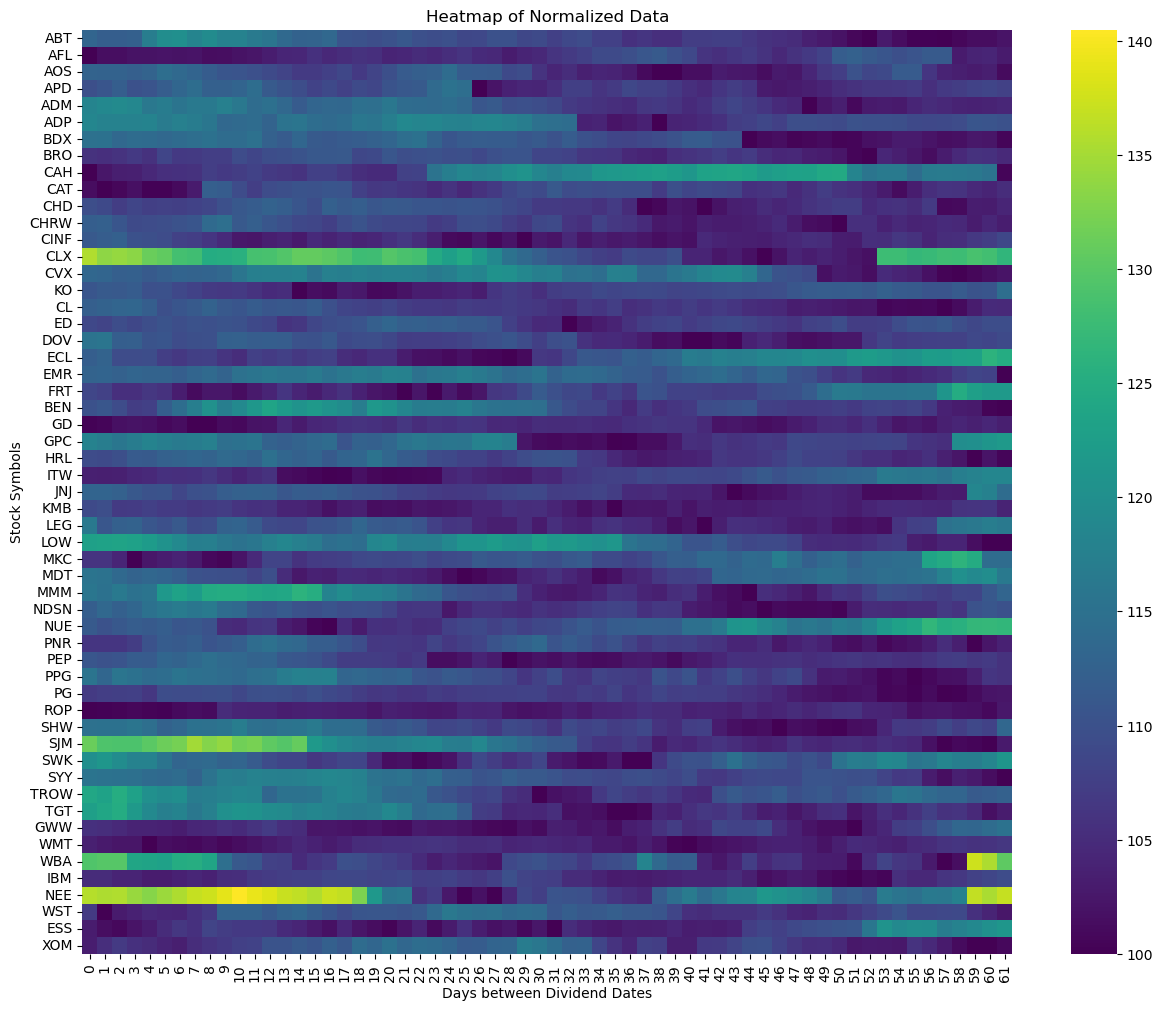

In [268]:
# DCS ALL: Heatmap

# Convert data to numeric format if necessary
normalized_df = normalized_df.apply(pd.to_numeric, errors = 'coerce')

# Create the heatmap
plt.figure(figsize = (15, 12))
sns.heatmap(normalized_df, cmap = 'viridis')
plt.title('Heatmap of Normalized Data')
plt.xlabel('Days between Dividend Dates')
plt.ylabel('Stock Symbols')
plt.show()
plt.close()

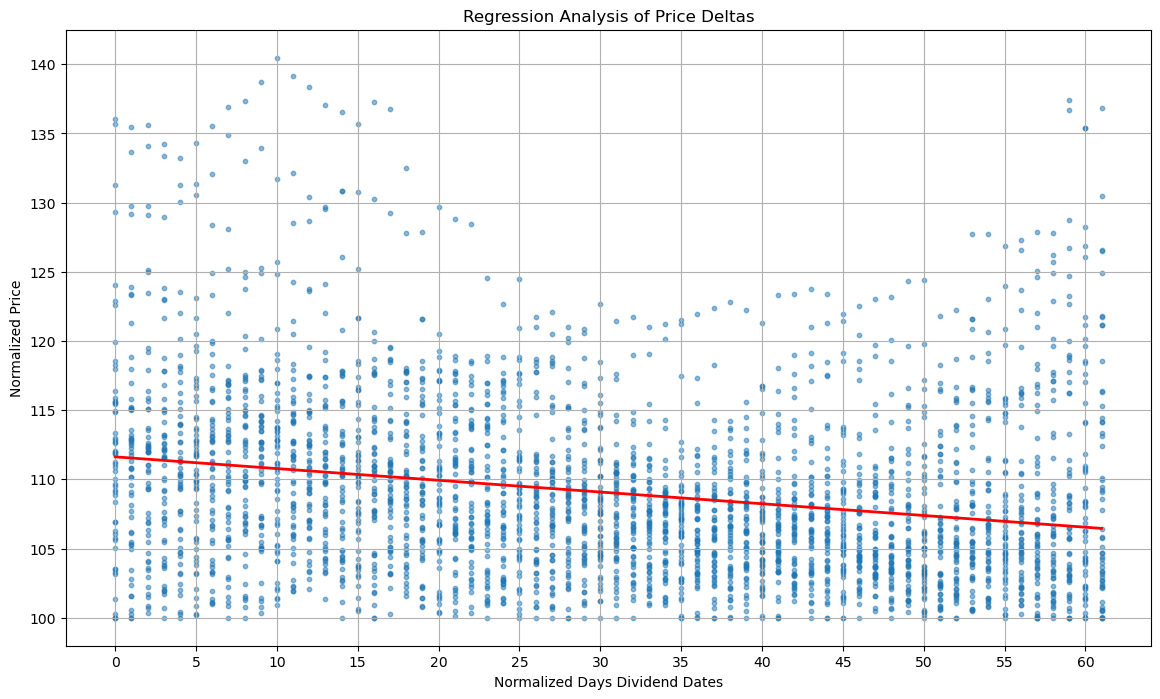

"\nR-squared: The R-squared value is 0.055, which means that approximately 5.5% of the variability in the dependent \nvariable (value) is explained by the independent variable (variable). This indicates a relatively weak relationship \nbetween the two variables.\n\nF-statistic: The F-statistic is 196.5 with a very low p-value (1.90e-43), indicating that the overall regression model \nis statistically significant. This suggests that the independent variable (variable) has a statistically significant \neffect on the dependent variable (value).\n\nCoefficient interpretation:\n\nThe coefficient for the constant term (const) is 111.6258. This represents the estimated value of the dependent variable \n(value) when the independent variable (variable) is zero. In this case, it likely represents the intercept of the \nregression line.\nThe coefficient for the variable (variable) is -0.0847. This represents the estimated change in the dependent variable \n(value) for a one-unit increase in the i

In [269]:
# DCS ALL: Linear Regression Analysis

#print(normalized_df)

columns = normalized_df.columns[0:62]

normalized_df_melt = pd.melt(normalized_df.reset_index(), id_vars = 'index', value_vars = columns)

#print(normalized_df_melt)

# Convert 'delta' and 'days_after_ex_dividend' columns to numeric dtype
normalized_df_melt['value'] = pd.to_numeric(normalized_df_melt['value'])
normalized_df_melt['variable'] = pd.to_numeric(normalized_df_melt['variable'])

# Perform regression analysis
X = sm.add_constant(normalized_df_melt['variable'])
model = sm.OLS(normalized_df_melt['value'], X)
results = model.fit()

# Print regression summary
#print(results.summary())

# Plot regression line
plt.figure(figsize=(14, 8))
plt.scatter(normalized_df_melt['variable'], normalized_df_melt['value'], alpha=0.5, s=10)
plt.plot(normalized_df_melt['variable'], results.predict(X), color='red', linewidth=2)
plt.xlabel('Normalized Days Dividend Dates')
plt.ylabel('Normalized Price')
plt.title('Regression Analysis of Price Deltas')
plt.grid(True)
#plt.xlim(0, 5)
#plt.ylim(-10, 10)
plt.xticks(np.arange(0, 101, step = 5))  # Adjust step size as needed
plt.locator_params(axis = 'x', tight=True)
plt.show()
plt.close()

"""
R-squared: The R-squared value is 0.055, which means that approximately 5.5% of the variability in the dependent 
variable (value) is explained by the independent variable (variable). This indicates a relatively weak relationship 
between the two variables.

F-statistic: The F-statistic is 196.5 with a very low p-value (1.90e-43), indicating that the overall regression model 
is statistically significant. This suggests that the independent variable (variable) has a statistically significant 
effect on the dependent variable (value).

Coefficient interpretation:

The coefficient for the constant term (const) is 111.6258. This represents the estimated value of the dependent variable 
(value) when the independent variable (variable) is zero. In this case, it likely represents the intercept of the 
regression line.
The coefficient for the variable (variable) is -0.0847. This represents the estimated change in the dependent variable 
(value) for a one-unit increase in the independent variable (variable), holding all other variables constant. 
Since the coefficient is negative, it suggests that there is a negative relationship between the independent variable 
and the dependent variable.

P-values: Both coefficients have p-values less than 0.05, indicating that they are statistically significant at the 
95% confidence level. This suggests that both the constant term and the independent variable have a significant effect 
on the dependent variable.

Omnibus and Jarque-Bera tests: These tests assess the normality of the residuals. The p-values for both tests are very 
low (close to 0), indicating that the residuals are not normally distributed. 
This suggests that the assumption of normality may be violated.

Durbin-Watson: The Durbin-Watson statistic is 2.140, which is close to 2. This suggests that there is little or no 
autocorrelation in the residuals.

Cond. No.: The condition number measures multicollinearity. A value greater than 30 indicates potential multicollinearity 
issues. In this case, the condition number is 69.9, suggesting moderate multicollinearity.

Overall, the regression model suggests that the independent variable (variable) has a statistically significant, 
albeit weak, negative effect on the dependent variable (value). However, it's important to consider the limitations 
of the model, such as the low R-squared value and potential violations of assumptions.
"""


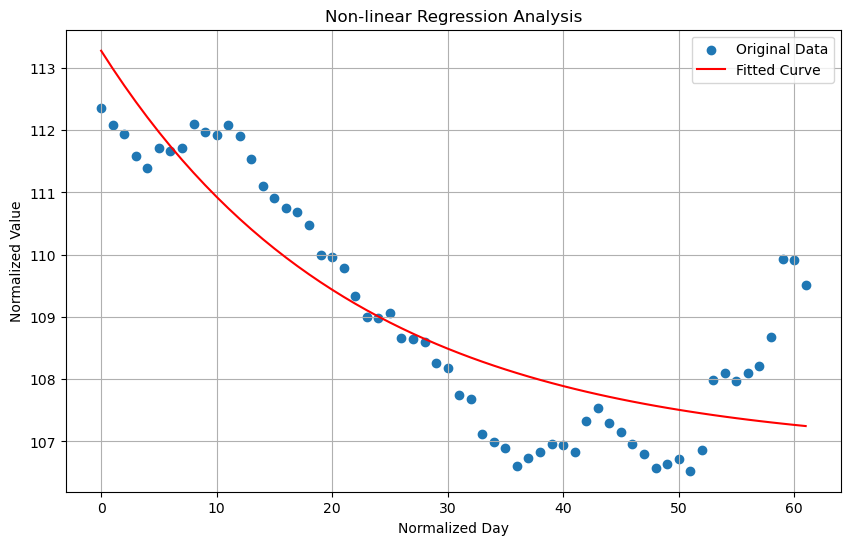

In [270]:
# DCS ALL: Non-Linear Regression Analysis

from scipy.optimize import curve_fit

#print(normalized_df)

# Define a non-linear function to fit to the data
def nonlinear_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Extract x and y values for the regression analysis
x_values = np.arange(len(normalized_df.columns))  # Use column indices as x values
y_values = normalized_df.mean(axis = 0).values     # Take the mean of each column as y values

# Provide initial guesses for the parameters
initial_guess = (1, 0.01, 1)

# Fit the non-linear function to the data
popt, pcov = curve_fit(nonlinear_func, x_values, y_values, p0 = initial_guess)

# Generate y values using the fitted function
fitted_y_values = nonlinear_func(x_values, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, label='Original Data')
plt.plot(x_values, fitted_y_values, 'r-', label='Fitted Curve')
plt.title('Non-linear Regression Analysis')
plt.xlabel('Normalized Day')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()
plt.close()


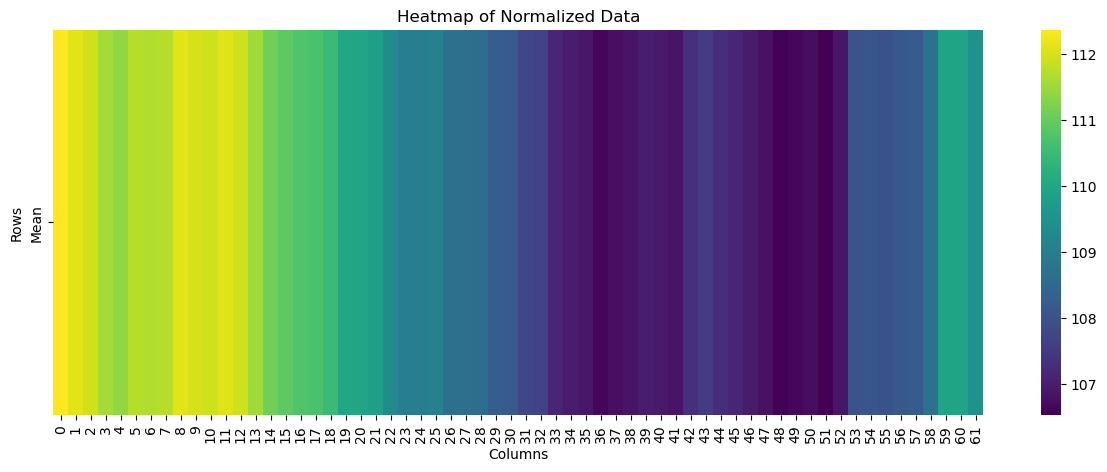

In [271]:
# DCS ALL: Aggregated Heatmap

# Create a new DataFrame containing the mean of each column
column_mean_df = pd.DataFrame(normalized_df.mean(), columns = ['Mean'])

column_mean_df_transp = column_mean_df.transpose()

# Create the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(column_mean_df_transp, cmap='viridis')
plt.title('Heatmap of Normalized Data')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
plt.close()


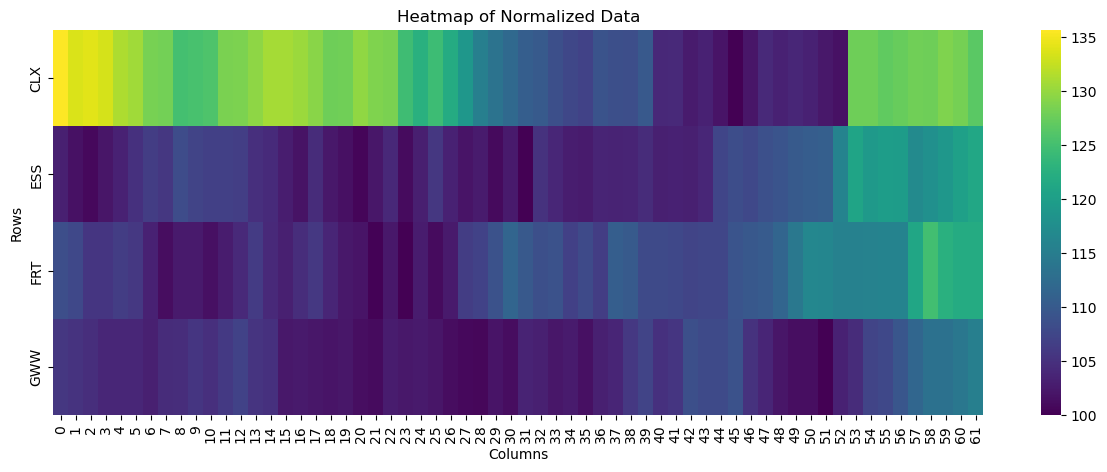

In [272]:
# DCS SELECTED: Heatmap

# Use loc to select rows by labels
normalized_df_selected = normalized_df.loc[symbols]
#print(normalized_df)

normalized_df_selected = normalized_df_selected.apply(pd.to_numeric, errors = 'coerce')

# Create the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(normalized_df_selected, cmap='viridis')
plt.title('Heatmap of Normalized Data')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
plt.close()


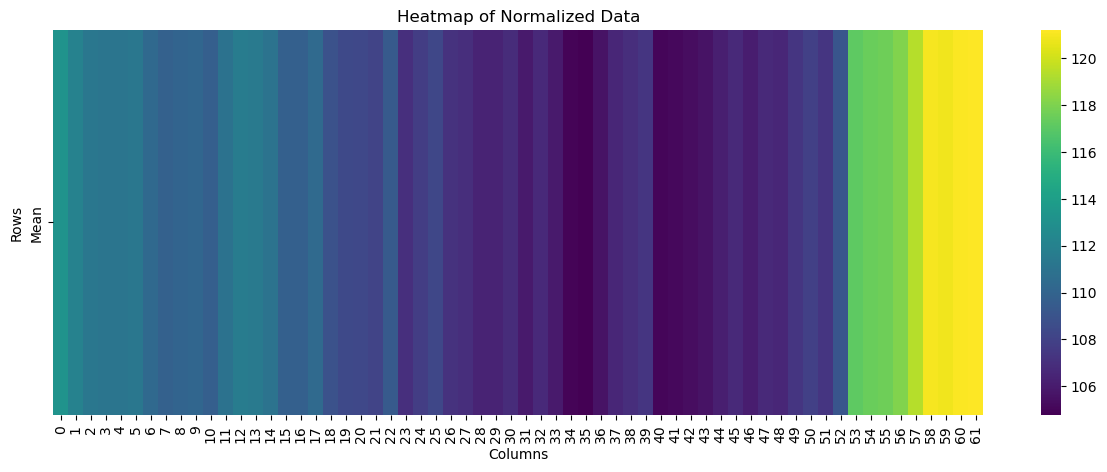

In [273]:
# DCS SELECTED: Aggregated Heatmap

# Create a new DataFrame containing the mean of each column

normalized_df_selected = pd.DataFrame(normalized_df_selected.mean(), columns = ['Mean'])
#print(normalized_df_selected)

normalized_df_selected_transp = normalized_df_selected.transpose()

# Create the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(normalized_df_selected_transp, cmap='viridis')
plt.title('Heatmap of Normalized Data')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
plt.close()


In [274]:
# All strategies: Performance Analysis

#print(final)

# Function to calculate yearly percentual returns for each strategy
def bh_perf_analysis(portfolio):
    
    sp_dd_da_merged_selected = portfolio
    #print(sp_dd_da_merged_selected)

#    da_lst_selected = lst_1 + lst_2

 #   sp_dd_da_merged_selected = sp_dd_da_merged_selected.sort_values(['symbol', 'date'], ascending = [True, True]).reset_index(
 #       drop = True)

  #  d = sp_dd_da_merged_selected[sp_dd_da_merged_selected["symbol"].isin(da_lst_selected)]

   # sp_dd_da_merged_selected = d
    #print(sp_dd_da_merged_selected)
    
    # Convert to string
    sp_dd_da_merged_selected["date"] = sp_dd_da_merged_selected["date"].astype(str)

    # Create key
    sp_dd_da_merged_selected["key"] = sp_dd_da_merged_selected["symbol"] + sp_dd_da_merged_selected["date"]

    # Convert to date / year formats
    sp_dd_da_merged_selected['date'] = pd.to_datetime(sp_dd_da_merged_selected['date'])
    sp_dd_da_merged_selected['year'] = sp_dd_da_merged_selected['date'].dt.year
    #print(sp_dd_da_merged_selected)

    # Group by symbol and year, and calculate annual means for dividends
    sp_dd_da_merged_selected_dividend = sp_dd_da_merged_selected.groupby(['symbol', 'year'])["dividend"].agg("sum") 
    #print(sp_dd_da_merged_selected_dividend)
    
    # Convert to dataframe and reset index
    sp_dd_da_merged_selected_dividend = pd.DataFrame(sp_dd_da_merged_selected_dividend)
    sp_dd_da_merged_selected_dividend.reset_index(inplace = True)
    #print(sp_dd_da_merged_selected_dividend)

    # Group by symbol and year, then find the minimum and maximum dates within each group
    grouped_dates_min = sp_dd_da_merged_selected.groupby(['symbol', 'year'])['date'].agg(['min'])
    grouped_dates_max = sp_dd_da_merged_selected.groupby(['symbol', 'year'])['date'].agg(['max'])

    # Reset index to make the grouped data easier to work with
    grouped_dates_min.reset_index(inplace = True)
    grouped_dates_max.reset_index(inplace = True)

    # Convert date columns to string
    grouped_dates_min["min"] = grouped_dates_min["min"].astype(str)
    grouped_dates_max["max"] = grouped_dates_max["max"].astype(str)

    # Create key column
    grouped_dates_min["key"] = grouped_dates_min["symbol"] + grouped_dates_min["min"]
    grouped_dates_max["key"] = grouped_dates_max["symbol"] + grouped_dates_max["max"]
    #print(grouped_dates_min)

    # Remove unnecesary columns
    remove = ["symbol", "year"]
    grouped_dates_min = grouped_dates_min[grouped_dates_min.columns.difference(remove)] 
    grouped_dates_max = grouped_dates_max[grouped_dates_max.columns.difference(remove)]

    # Merge dataframes to retrieve prices on first dates of each year of each symbol 
    grouped_dates_min = pd.merge(grouped_dates_min, sp_dd_da_merged_selected, on = ["key"], how = "inner")
    grouped_dates_min = grouped_dates_min.rename(columns = {"close_adjusted": "price_primo"})
    #print(grouped_dates_min)

    # Merge dataframes to retrieve prices on last dates of each year of each symbol
    grouped_dates_max = pd.merge(grouped_dates_max, sp_dd_da_merged_selected, on = ["key"], how = "inner")
    grouped_dates_max = grouped_dates_max.rename(columns = {"close_adjusted": "price_ultimo"})

    # Remove unnecessary columns
    remove = ["dividend", "date", "key", "year", "min", "max", "symbol"]
    grouped_dates_min = grouped_dates_min[grouped_dates_min.columns.difference(remove)] 
    grouped_dates_max = grouped_dates_max[grouped_dates_max.columns.difference(remove)]
    #print(grouped_dates_min)

    # Concatenate dataframes with first and last dates of each symbol of each year
    grouped_dates_final = pd.concat([grouped_dates_min, grouped_dates_max, sp_dd_da_merged_selected_dividend], axis = 1)
    #print(grouped_dates_final)

####################################################################    

    # Replace NaN's with 0's to ensure correct calculations 
    grouped_dates_final["dividend"] = grouped_dates_final["dividend"].fillna(0)
    #print(grouped_dates_final)
    
    # Calculate delta between price end of year and beginning of year
    grouped_dates_final["diff"] = grouped_dates_final["price_ultimo"] + grouped_dates_final[
        "dividend"] - grouped_dates_final["price_primo"] 
    #print(grouped_dates_final)

####################################################################
    # Sort the DataFrame by the 'date' column
    grouped_dates_final.sort_values(by = ["symbol",'year'], inplace = True)
    #print(grouped_dates_final)
    
    # Calculate delta incl taxes
    #grouped_dates_final["diff_inc_tax"] = grouped_dates_final["diff"] * (1 - tax_rate_bh)
    #print(grouped_dates_final)
    
    # Group data columns by year
#    grouped_dates_final = grouped_dates_final.groupby(grouped_dates_final["year"]).agg(
 #       diff_inc_tax = ("diff_inc_tax", "sum"), price_primo = ("price_primo", "sum"), price_ultimo = (
  #      "price_ultimo", "sum"), dividend = ("dividend", "sum")).reset_index()
    #print(grouped_dates_final)

    # Group data columns by year
    grouped_dates_final = grouped_dates_final.groupby(grouped_dates_final["year"]).agg(price_primo = (
        "price_primo", "mean"), price_ultimo = ("price_ultimo", "mean"), dividend = ("dividend", "mean"), diff = (
        "diff", "mean")).reset_index()
    #print(grouped_dates_final)
    
    # Calculate percentual difference between price end of year and beginning of year
    grouped_dates_final["diff_perc"] = (grouped_dates_final["price_ultimo"] + grouped_dates_final[
        "dividend"] - grouped_dates_final["price_primo"]) / grouped_dates_final["price_primo"]  
    #print(grouped_dates_final)
    
    # Remove unnecessary columns
    remove = ["price_primo", "price_ultimo", "dividend"]
    grouped_dates_final = grouped_dates_final[grouped_dates_final.columns.difference(remove)] 
    #print(grouped_dates_final)
    
    # Step 2: Normalize the values so that the values for 1998 are normalized to 100
    #grouped_dates_final["normalized_DABH_Selected"] = grouped_dates_final[
    #    "diff_inc_tax"] / grouped_dates_final.iloc[0]["diff_inc_tax"] * 100

    return grouped_dates_final

remove = ["year", "diff_inc_tax"]
#remove = ["year", "diff_perc"]


# DCS HALFWAY
#print(final)
final["dcs_halfway_dollar"] = (final["diff_x"] + final["diff_y"]) / 2
selected_columns = ['dcs_halfway_dollar', 'diff_perc']
dcs_halfway = final[selected_columns]
dcs_halfway = dcs_halfway.rename(columns = {"diff_perc": "dcs_halfway_perc"})
#print(dcs_halfway)

# RISK-FREE RATE
rf = rf.reset_index(drop = True)
rf_calc = rf
# Perform the calculation
rf_calc = (rf_calc / 100) #* 0.6
#dataframe['column'] = dataframe['column'].astype(float)
rf_calc = rf_calc.astype(float)
#rf = rf_calc
#print(rf_calc)

# B&H SELECTED
bh_selected = all_data_cleaned 
bh_selected_portfolio = lst_1 + lst_2
bh_selected = bh_selected[bh_selected["symbol"].isin(bh_selected_portfolio)]
bh_perf_selected_final = bh_perf_analysis(bh_selected)
bh_perf_selected_final = bh_perf_selected_final[bh_perf_selected_final.columns.difference(remove)]
bh_perf_selected_final = bh_perf_selected_final.rename(columns = {"diff": "bh_selected_dollar"})
bh_perf_selected_final = bh_perf_selected_final.rename(columns = {"diff_perc": "bh_selected_perc"})
#print(bh_perf_selected_final)

# B&H ALL / DCS ALL
bh_all = all_data_cleaned
#print(all_data_cleaned)
bh_all_portfolio = da["symbol"].tolist()
bh_all = bh_all[bh_all["symbol"].isin(bh_all_portfolio)]
#print(bh_all)
bh_perf_all_final = bh_perf_analysis(bh_all)
#print(bh_perf_all_final)
bh_perf_all_final = bh_perf_all_final[bh_perf_all_final.columns.difference(remove)]
bh_perf_all_final = bh_perf_all_final.rename(columns = {"diff": "bh_all_dollar"})
bh_perf_all_final = bh_perf_all_final.rename(columns = {"diff_perc": "bh_all_perc"})
#print(bh_perf_all_final)

# SP 500
sp500 = all_data_cleaned 
sp500 = sp500[sp500["symbol"] == "IVV"]
#print(sp500)
#sp500_portfolio = da["symbol"].tolist()
#sp500 = sp500[sp500["symbol"].isin(sp500_portfolio)]
sp500_final = bh_perf_analysis(sp500)
#print(sp500_final)
sp500_final = sp500_final[sp500_final.columns.difference(remove)]
sp500_final = sp500_final.rename(columns = {"diff": "sp500_dollar"})
sp500_final = sp500_final.rename(columns = {"diff_perc": "sp500_perc"})
#print(sp500_final)

"""
# NASDAQ
nasdaq = all_data_cleaned 
nasdaq = nasdaq[nasdaq["symbol"] == "QQQ"]
#print(nasdaq)
#sp500_portfolio = da["symbol"].tolist()
#sp500 = sp500[sp500["symbol"].isin(sp500_portfolio)]
nasdaq_final = bh_perf_analysis(nasdaq)
nasdaq_final = nasdaq_final[nasdaq_final.columns.difference(remove)]
nasdaq_final = nasdaq_final.rename(columns = {"diff": "nasdaq_dollar"})
nasdaq_final = nasdaq_final.rename(columns = {"diff_perc": "nasdaq_perc"})
#print(nasdaq_final)
"""

C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\2174443104.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_dd_da_merged_selected["date"] = sp_dd_da_merged_selected["date"].astype(str)
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\2174443104.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_dd_da_merged_selected["key"] = sp_dd_da_merged_selected["symbol"] + sp_dd_da_merged_selected["date"]
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\2174443104.py:28: SettingWithCopyWarning: 
A value

'\n# NASDAQ\nnasdaq = all_data_cleaned \nnasdaq = nasdaq[nasdaq["symbol"] == "QQQ"]\n#print(nasdaq)\n#sp500_portfolio = da["symbol"].tolist()\n#sp500 = sp500[sp500["symbol"].isin(sp500_portfolio)]\nnasdaq_final = bh_perf_analysis(nasdaq)\nnasdaq_final = nasdaq_final[nasdaq_final.columns.difference(remove)]\nnasdaq_final = nasdaq_final.rename(columns = {"diff": "nasdaq_dollar"})\nnasdaq_final = nasdaq_final.rename(columns = {"diff_perc": "nasdaq_perc"})\n#print(nasdaq_final)\n'

In [409]:
# All strategies: Sharpe and Sortino Ratio Analysis

#print(df_all)
#print(trades_df)

# DCS OPTIMAL
#selected_columns = ['profit', "diff_perc"]
selected_columns = ['profit', "diff_perc", "diff_reinv", "diff_perc_reinv"]
dcs_optimal = trades_df[selected_columns]
dcs_optimal = dcs_optimal.rename(columns = {"diff_perc": "dcs_optimal_perc"})
dcs_optimal = dcs_optimal.rename(columns = {"profit": "dcs_optimal_dollar"})

# Concatenate all the performance DataFrames along the columns axis
all_perf = pd.concat(
    [sp500_final, nasdaq_final, bh_perf_selected_final, bh_perf_all_final, rf_calc, dcs_halfway, dcs_optimal], axis = 1)
#print(all_perf)

#all_perf = all_perf.rename(columns = {"dollar_gains": "dcs_halfway_dollar"})
#all_perf = all_perf.rename(columns = {"profit": "dcs_optimal_dollar"})
all_perf = all_perf.rename(columns = {"diff_reinv_perc": "dcs_optimal_reinv_perc"})
all_perf = all_perf.rename(columns = {"diff_reinv": "dcs_optimal_reinv_dollar"})
#print(all_perf)

# Define range of data
years = range(start_year, end_year + 1)
# Set the 'years' list as the new index of the DataFrame
all_perf.index = years
#print(all_perf)

dollar_gains = all_perf.filter(regex = "dollar")
all_perf = all_perf[all_perf.columns.drop(list(all_perf.filter(regex = "dollar")))]
#print(all_perf)

def calculate_sortino_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    #print(excess_returns)
    downside_returns = returns[returns < 0]
    downside_deviation = np.std(downside_returns)
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    return sortino_ratio

# Step 2: Apply the function to each portfolio column in the DataFrame
portfolio_sortino_ratios = {}
for column in all_perf.columns:
    if column != 'rf':
        portfolio_returns = all_perf[column]
        #print(portfolio_returns)
        risk_free_rate = all_perf['rf']
        #print(risk_free_rate)
        sortino_ratio = calculate_sortino_ratio(portfolio_returns, risk_free_rate)
        portfolio_sortino_ratios[column] = sortino_ratio

# Step 3: Store the Sortino ratios in a new DataFrame
sortino_ratio_df = pd.DataFrame(portfolio_sortino_ratios.items(), columns = ['Portfolio', 'Sortino_Ratio'])

# Print the DataFrame with Sortino ratios
print(sortino_ratio_df)



def calculate_yearly_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    yearly_std_dev = np.std(returns)
    yearly_sharpe_ratio = np.mean(excess_returns) / yearly_std_dev
    return yearly_sharpe_ratio

# Step 2: Calculate Sharpe ratio for each portfolio based on yearly returns
portfolio_sharpe_ratios = {}
for column in all_perf.columns:
    if column != 'rf':
        portfolio_returns = all_perf[column]
        risk_free_rate = all_perf['rf']
        yearly_sharpe_ratio = calculate_yearly_sharpe_ratio(portfolio_returns, risk_free_rate)
        portfolio_sharpe_ratios[column] = yearly_sharpe_ratio

# Step 3: Store the Sharpe ratios in a new DataFrame
sharpe_ratio_df = pd.DataFrame(portfolio_sharpe_ratios.items(), columns = ['Portfolio', 'Sharpe_Ratio'])

# Print the DataFrame with Yearly Sharpe ratios
print(sharpe_ratio_df)

##########################################################################
# EKSL skat
##########################################################################
#Sharpe ratios are better at analyzing portfolios that have low volatility 
#while Sortino ratio is better when analyzing highly volatile portfolios.
##########################################################################
#Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors
#A good Sortino ratio is one with a score of 2 or above, but some investors might accept lower ratios depending on their
#risk preferences
##########################################################################

all_perf_max_drawdown = all_perf
#print(all_perf_max_drawdown)

# Unpivot df and rename columns
all_perf_max_drawdown = pd.melt(all_perf_max_drawdown.reset_index(), id_vars = 'index', value_vars = None)
all_perf_max_drawdown = all_perf_max_drawdown.rename(columns = {"index": "year", "variable": "symbol_start", "value": "stock_returns"})
#print(all_perf_max_drawdown)


#selected_columns = ["bh_selected_perc", "bh_all_perc", "dcs_halfway_perc", "dcs_optimal_perc", "diff_perc_reinv"]
selected_columns = ["dcs_halfway_perc", "dcs_optimal_perc", "diff_perc_reinv"]
all_perf = all_perf[selected_columns]
#print(all_perf)

# Unpivot df and rename columns
all_perf = pd.melt(all_perf.reset_index(), id_vars = 'index', value_vars = selected_columns)
all_perf = all_perf.rename(columns = {"index": "year", "variable": "symbol_start", "value": "stock_returns"})

#print(all_perf)


          Portfolio  Sortino_Ratio
0        sp500_perc       0.924419
1       nasdaq_perc       0.846203
2  bh_selected_perc       2.907517
3       bh_all_perc       2.087491
4  dcs_halfway_perc       8.006537
5  dcs_optimal_perc       3.239562
6   diff_perc_reinv       4.284578
          Portfolio  Sharpe_Ratio
0        sp500_perc      0.557582
1       nasdaq_perc      0.448107
2  bh_selected_perc      0.897672
3       bh_all_perc      1.050854
4  dcs_halfway_perc      1.387645
5  dcs_optimal_perc      0.457021
6   diff_perc_reinv      0.452446
     year     symbol_start  stock_returns
0    2001       sp500_perc      -0.085395
1    2002       sp500_perc      -0.203356
2    2003       sp500_perc       0.278247
3    2004       sp500_perc       0.134303
4    2005       sp500_perc       0.079091
..    ...              ...            ...
179  2019  diff_perc_reinv       0.017439
180  2020  diff_perc_reinv      -0.011342
181  2021  diff_perc_reinv       0.040248
182  2022  diff_perc_reinv  

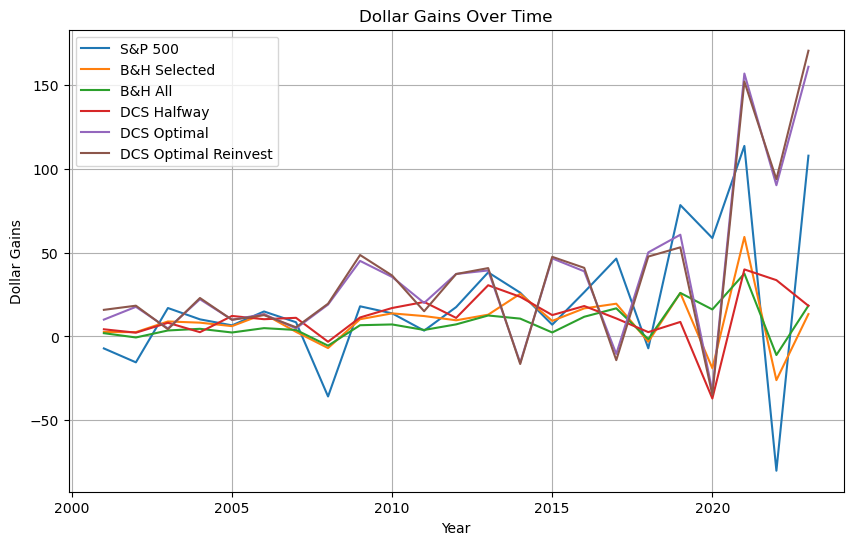

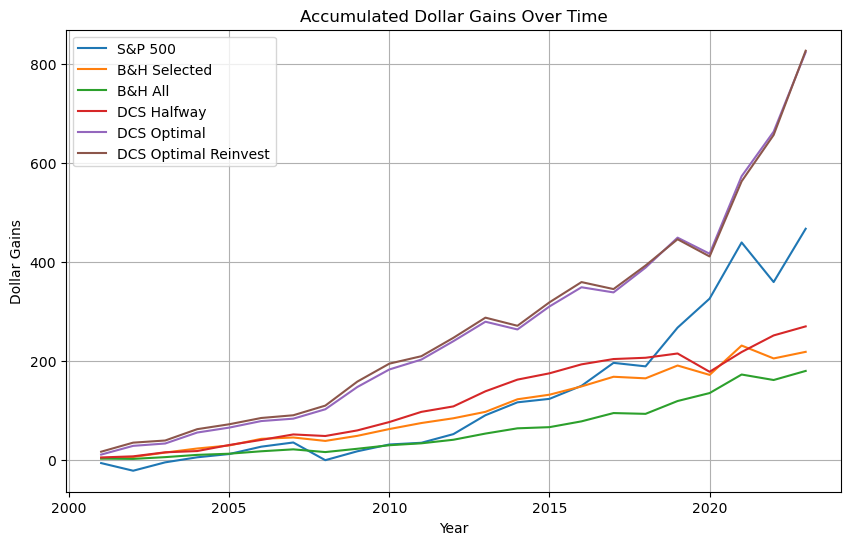

In [309]:
# All strategies: Dollar-gains

    
# Data
years = range(start_year, start_year + len(dollar_gains))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, dollar_gains['sp500_dollar'], label='S&P 500')
#plt.plot(years, dollar_gains['nasdaq_dollar'], label='NASDAQ')
plt.plot(years, dollar_gains['bh_selected_dollar'], label='B&H Selected')
plt.plot(years, dollar_gains['bh_all_dollar'], label='B&H All')
plt.plot(years, dollar_gains['dcs_halfway_dollar'], label='DCS Halfway')
plt.plot(years, dollar_gains['dcs_optimal_dollar'], label='DCS Optimal')
plt.plot(years, dollar_gains['dcs_optimal_reinv_dollar'], label='DCS Optimal Reinvest')


plt.xlabel('Year')
plt.ylabel('Dollar Gains')
plt.title('Dollar Gains Over Time')
plt.legend()
plt.grid(True)
plt.show()





# Initialize dollar_gains_acc with the values from dollar_gains
dollar_gains_acc = dollar_gains.copy()

# Calculate the cumulative sum for each column in dollar_gains_acc
for i in dollar_gains_acc.columns:
    dollar_gains_acc[i] = dollar_gains_acc[i].cumsum()

#print(dollar_gains_acc)

plt.figure(figsize=(10, 6))
plt.plot(years, dollar_gains_acc['sp500_dollar'], label='S&P 500')
#plt.plot(years, dollar_gains_acc['nasdaq_dollar'], label='NASDAQ')
plt.plot(years, dollar_gains_acc['bh_selected_dollar'], label='B&H Selected')
plt.plot(years, dollar_gains_acc['bh_all_dollar'], label='B&H All')
plt.plot(years, dollar_gains_acc['dcs_halfway_dollar'], label='DCS Halfway')
plt.plot(years, dollar_gains_acc['dcs_optimal_dollar'], label='DCS Optimal')
plt.plot(years, dollar_gains['dcs_optimal_reinv_dollar'], label='DCS Optimal Reinvest')


plt.xlabel('Year')
plt.ylabel('Dollar Gains')
plt.title('Accumulated Dollar Gains Over Time')
plt.legend()
plt.grid(True)
plt.show()


## SDY (fra 2006) (eller NOBL, fra 2013)
## CORRELATION ML STRATEGIER OG SP500!!!!!!!!!!!!!!!!!!!


# REFLECTIONS:
# When applying F&F / Sortino/Sharpe to select the best shares, dcs_optimal is out-performed by other strategies. 
#However, when selecting shares that, still within top-performers (>2 sortino) with more similar price patterns,
# dcs_optimal is the best performing strategy. Note also, that the strategy has a 2.9 sortino ratio, indicating a favorable
# negative volitality-reward ratio
# Furthermore, the strategy seemingly has little or negative correlation to S&P 500 or NASDAQ, thus being a potential 
#risk-hedging strategy-although in 2022 the strategy was also negatively affected by the bear market
# This is notwithstanding the lacking statistical evidence of the intra-dividend price pattern



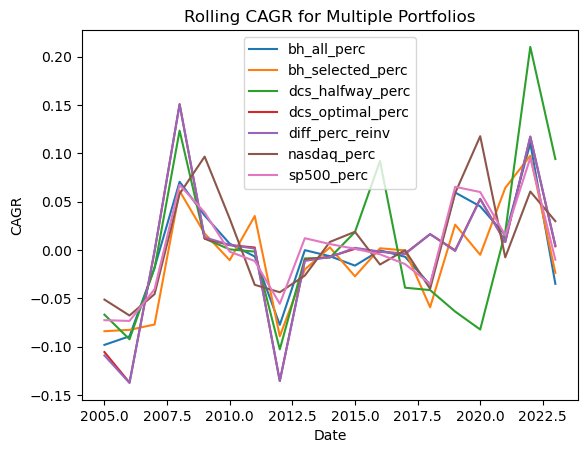

<Figure size 2000x1000 with 0 Axes>

In [310]:
# All strategies: CAGR (Compound Annual Growth Rate)


# DATA PREPARATION: ADJUST DATA BY MINIMUM VALUES TO GET RID OF NEGATIVE VALUES

# Initialize an empty DataFrame to store the corrected data
corrected_df = pd.DataFrame()

# Find the minimum negative value across all portfolios for each time period
min_negative_values = all_perf.min(axis=1)
#print(min_negative_values)

# Iterate over each column (portfolio) in the concatenated DataFrame
for col in all_perf.columns:
    
    # Extract the portfolio data for the current column
    portfolio_data = all_perf[col]
    
    # Subtract the minimum negative value for the corresponding time period from the portfolio data
    corrected_portfolio_data = portfolio_data - min_negative_values
    
    # If the minimum negative value for the time period is NaN, set it to 0
    min_negative_values_filled = min_negative_values.fillna(0)
    
    # Add the absolute value of the smallest negative value plus one to correct negative values
    corrected_portfolio_data += abs(min_negative_values_filled) + 1
    
    # Append the corrected column to the DataFrame
    corrected_df[col] = corrected_portfolio_data

# Print the corrected DataFrame
#print(corrected_df)

# Change name and delete column
cagr = corrected_df
remove = ["rf"]  # If 'rf' is not a column, this will raise an error
cagr = cagr[cagr.columns.difference(remove)]

#print(cagr)


# CALCULATE CAGR

def rolling_cagr(data, window_size):
    rolling_cagr_values = []

    # Calculate rolling CAGR for each portfolio
    for portfolio in data.columns:
        portfolio_rolling_cagr = []
        
        for i in range(len(data) - window_size + 1):
            window_data = data[portfolio].iloc[i:i + window_size]
            
            start_value = window_data.iloc[0]
            #print(start_value)
            
            end_value = window_data.iloc[-1]
            #print(end_value)
            
            cagr_value = (end_value / start_value) ** (1 / (window_size - 1)) - 1
            #print(cagr_value)
            
            portfolio_rolling_cagr.append(cagr_value)
        
        # Pad the rolling CAGR values with NaNs to match the length of the original data
        portfolio_rolling_cagr = [None] * (window_size - 1) + portfolio_rolling_cagr
        rolling_cagr_values.append(portfolio_rolling_cagr)

    return rolling_cagr_values

# Calculate rolling CAGR for each portfolio with a window size of 5 (for example)
rolling_cagr_values = rolling_cagr(cagr, window_size = 5)

# Plot the rolling CAGR values for each portfolio
for i, col in enumerate(cagr.columns):
    plt.plot(cagr.index, rolling_cagr_values[i], label=col)

plt.xlabel('Date')
plt.ylabel('CAGR')
plt.title('Rolling CAGR for Multiple Portfolios')
plt.legend()
plt.figure(figsize = (20, 10))
plt.show()
plt.close()


In [311]:
#Fama & French: Data Preparation

#Fetch data
# Define the URL for Fama/French Factors data
url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

# Read the CSV file from the ZIP archive
factors_data = pd.read_csv(url, skiprows = 3, index_col = 0)

# Extract the market returns, SMB, HML, RMW and CMA columns
market_returns = factors_data[['Mkt-RF']]
smb = factors_data[['SMB']]
hml = factors_data[['HML']]
rmw = factors_data[['RMW']]
cma = factors_data[['CMA']]

# Select the relevant portion of factors_data starting from the row specified by factor_input
factors_data = factors_data[factor_input:]

# Create a 'year' column from the index of factors_data
factors_data["year"] = factors_data.index

# Convert the 'year' column to datetime format
factors_data['year'] = pd.to_datetime(factors_data['year'])

# Extract the year from the datetime and update the 'year' column
factors_data['year'] = factors_data['year'].dt.year

# Drop the 'year' column from the list of columns
cols = factors_data.columns.drop('year')

# Convert the remaining columns to numeric, coercing errors to NaN
factors_data[cols] = factors_data[cols].apply(pd.to_numeric, errors='coerce')

#print(factors_data)

In [354]:
# BETA

# Filter out NASDAQ as beta is based on SP 500
lst = ["^IXIC"]

# Create a boolean mask where True indicates rows to keep
mask = ~ ff['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
ff_beta = ff[mask]

ff_beta = set(list(ff["symbol"]))
#print(ff_beta)

# Initialise a DataFrame with the columns
beta = pd.DataFrame(columns = ['symbol', 'beta', 'Marketcap'])

# Initialize an empty DataFrame for historical data
historical_beta_data = pd.DataFrame()

for stock in ff_beta:
    for year in range(start_year, end_year + 1):
        
        # Fetch historical price data
        ticker = yf.Ticker(stock)
        hist_data = ticker.history(start = str(year) + '-01-01', end = str(year) + '-12-31')
        
        # Calculate beta value
        hist_data['Daily_Return'] = hist_data['Close'].pct_change()
        market_returns = yf.Ticker('^GSPC').history(start = str(year) + '-01-01', end = str(
            year) + '-12-31')['Close'].pct_change()
        cov_matrix = hist_data['Daily_Return'].cov(market_returns)
        market_var = market_returns.var()
        beta_value = cov_matrix / market_var
        
        # Append beta data to the DataFrame
        beta_data = pd.DataFrame({'symbol': [stock], 'year': [year], 'beta': [beta_value]})
        historical_beta_data = pd.concat([historical_beta_data, beta_data], ignore_index = True)

# Print the historical beta data
#print(historical_beta_data)

beta_avg = historical_beta_data.groupby("symbol").agg(beta = ("beta", "mean")).reset_index()
#print(beta_avg)


DOV: No price data found, symbol may be delisted (1d 2001-01-01 -> 2001-12-31)


   symbol      beta
0     ABT  0.745025
1     ADM  0.856141
2     ADP  0.885119
3     AFL  1.029260
4     ALB  1.280428
5     AOS  1.065839
6     APD  0.991013
7     BDX  0.677881
8     BEN  1.382461
9     BRO  0.781342
10    CAH  0.784093
11    CAT  1.207122
12    CHD  0.490576
13   CHRW  0.909314
14   CINF  0.928819
15     CL  0.518306
16    CLX  0.426966
17    CVX  0.890433
18    DOV  1.187376
19    ECL  0.901033
20     ED  0.406495
21    EMR  1.115085
22    ESS  0.777620
23    FRT  0.797461
24     GD  0.815673
25    GPC  0.853662
26    GWW  0.954497
27    HRL  0.515215
28    IBM  0.834818
29    ITW  1.046472
30    IVV  0.987723
31    JNJ  0.542852
32    KMB  0.502895
33     KO  0.546480
34    LEG  1.062713
35    LOW  1.077530
36    MDT  0.741516
37    MKC  0.534846
38    MMM  0.872940
39   NDSN  1.294899
40    NEE  0.558744
41    NUE  1.360470
42      O  0.745756
43    PEP  0.523824
44     PG  0.522991
45    PNR  1.117329
46    PPG  1.083245
47    QQQ  1.181248
48    ROP  1.040289


In [355]:
#print(beta_avg)

# INDIVIDUAL SYMBOLS: Fama & French: Data Preparation

#Fetch data
# Define the URL for Fama/French Factors data
url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

# Read the CSV file from the ZIP archive
factors_data = pd.read_csv(url, skiprows = 3, index_col = 0)

# Extract the market returns, SMB, HML, RMW and CMA columns
market_returns = factors_data[['Mkt-RF']]
smb = factors_data[['SMB']]
hml = factors_data[['HML']]
rmw = factors_data[['RMW']]
cma = factors_data[['CMA']]

# Select the relevant portion of factors_data starting from the row specified by factor_input
factors_data = factors_data[factor_input:]

# Create a 'year' column from the index of factors_data
factors_data["year"] = factors_data.index

# Convert the 'year' column to datetime format
factors_data['year'] = pd.to_datetime(factors_data['year'])

# Extract the year from the datetime and update the 'year' column
factors_data['year'] = factors_data['year'].dt.year

# Drop the 'year' column from the list of columns
cols = factors_data.columns.drop('year')

# Convert the remaining columns to numeric, coercing errors to NaN
factors_data[cols] = factors_data[cols].apply(pd.to_numeric, errors='coerce')

#print(factors_data)


   symbol      beta
0     ABT  0.745025
1     ADM  0.856141
2     ADP  0.885119
3     AFL  1.029260
4     ALB  1.280428
5     AOS  1.065839
6     APD  0.991013
7     BDX  0.677881
8     BEN  1.382461
9     BRO  0.781342
10    CAH  0.784093
11    CAT  1.207122
12    CHD  0.490576
13   CHRW  0.909314
14   CINF  0.928819
15     CL  0.518306
16    CLX  0.426966
17    CVX  0.890433
18    DOV  1.187376
19    ECL  0.901033
20     ED  0.406495
21    EMR  1.115085
22    ESS  0.777620
23    FRT  0.797461
24     GD  0.815673
25    GPC  0.853662
26    GWW  0.954497
27    HRL  0.515215
28    IBM  0.834818
29    ITW  1.046472
30    IVV  0.987723
31    JNJ  0.542852
32    KMB  0.502895
33     KO  0.546480
34    LEG  1.062713
35    LOW  1.077530
36    MDT  0.741516
37    MKC  0.534846
38    MMM  0.872940
39   NDSN  1.294899
40    NEE  0.558744
41    NUE  1.360470
42      O  0.745756
43    PEP  0.523824
44     PG  0.522991
45    PNR  1.117329
46    PPG  1.083245
47    QQQ  1.181248
48    ROP  1.040289


In [374]:

# Initialize an empty DataFrame for historical beta data
historical_beta_data_dcs = pd.DataFrame()

for year in range(start_year, end_year + 1):
    # Fetch historical price data for the market index
    market_data = yf.Ticker('^GSPC').history(start = f'{year}-01-01', end = f'{year}-12-31')
    market_returns = market_data['Close'].pct_change().dropna()
    
    stock_betas = []
    stock_prices = []
    
    for stock in symbols:
        # Fetch historical price data for the stock
        stock_data = yf.Ticker(stock).history(start = f'{year}-01-01', end = f'{year}-12-31')
        stock_returns = stock_data['Close'].pct_change().dropna()
        
        if not stock_returns.empty and not market_returns.empty:
            # Calculate the covariance between stock returns and market returns
            cov_matrix = stock_returns.cov(market_returns)
            market_var = market_returns.var()
            
            if pd.notna(cov_matrix) and pd.notna(market_var) and market_var != 0:
                # Compute beta value
                beta_value = cov_matrix / market_var
                stock_betas.append(beta_value)
                
                # Get the last available price of the stock for weighting
                stock_prices.append(stock_data['Close'].iloc[-1])
            else:
                print(f"Skipped {stock} in {year} due to invalid cov_matrix or market_var")
        else:
            print(f"No data for {stock} in {year}")

    if stock_betas and stock_prices:
        # Calculate the weighted average beta for the portfolio
        weights = np.array(stock_prices) / np.sum(stock_prices)
        portfolio_beta = np.sum(weights * np.array(stock_betas))
        
        # Append beta data to the DataFrame
        beta_data = pd.DataFrame({'symbol': ['portfolio'], 'year': [year], 'beta': [portfolio_beta]})
        historical_beta_data_dcs = pd.concat([historical_beta_data_dcs, beta_data], ignore_index=True)
    else:
        print(f"No valid data to calculate portfolio beta in {year}")

# Group by symbol and calculate the mean beta for each portfolio
beta_avg_dcs = historical_beta_data_dcs.groupby("symbol").agg(beta_dcs=("beta", "mean")).reset_index()

# Print the average beta values for each portfolio
#print(beta_avg_dcs)


      symbol  beta_dcs
0  portfolio  0.785244


In [378]:
# INDIVIDUAL SYMBOLS: Fama French 5-Factor Model

#print(ff)

# List of symbols to filter out
lst = ["^IXIC", "^GSPC"]

# Create a boolean mask where True indicates rows to keep
mask = ~ ff['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
ff = ff[mask]

ff['date'] = pd.to_datetime(ff['date'])
ff['year'] = ff['date'].dt.year

#--------------------------------------------------------------------------------
#DIVIDEND

# Create df containing yearly dividends for all stocks
dividend = ff.fillna(0, inplace = True)
dividend = ff.groupby(["year", "symbol"]).agg(dividend = ("dividend", "sum")).reset_index()
#print(dividend)

#--------------------------------------------------------------------------------

# CALCULATE ANNUAL PERCENTUAL PERFORMANCE / METRICS AS INPUT TO FF

# Group the dataframe by year and select the first and last rows for each year
res = ff.groupby(ff["year"]).apply(lambda x: x.iloc[[0, -1]])
res.index = res.index.droplevel(0)
res = res.reset_index()

# Initialize lists to store start and end dates
start_dates = []
end_dates = []

# Iterate over the dataframe to populate start and end dates
for i in res.index:
    if i % 2 == 0:
        start_dates.append(str(res["date"][i]))  # Append start date
    elif i % 2 != 0:
        end_dates.append(str(res["date"][i]))  # Append end date
    else:
        end_dates.append(str(res["date"][i]))

# Convert start_dates to a set and sort it
start_dates = set(start_dates)
s_start = sorted(start_dates)
s_start = pd.DataFrame(s_start)
s_start = s_start.rename(columns = {s_start.columns[0]: "date"}, inplace = False)
s_start['date'] = pd.to_datetime(s_start['date'])
s_start['year'] = s_start['date'].dt.year

# Convert end_dates to a set and sort it
end_dates = set(end_dates)
s_end = sorted(end_dates)
s_end = pd.DataFrame(s_end)
s_end = s_end.rename(columns = {s_end.columns[0]: "date"}, inplace = False)
s_end['date'] = pd.to_datetime(s_end['date'])
s_end['year'] = s_end['date'].dt.year

# Merge the start dates with the original dataframe
ff_start = pd.merge(ff, s_start, on = "date", how = "inner")
ff_start = ff_start.rename(columns = {"close_adjusted": "close_adjusted_start"})
ff_start = ff_start.rename(columns = {"symbol": "symbol_start"})
cols = [2,4]  # Columns to drop
ff_start = ff_start.drop(ff_start.columns[cols], axis = 1, inplace = False)

# Merge the end dates with the original dataframe
ff_end = pd.merge(ff, s_end, on = "date", how = "inner")
ff_end = ff_end.rename(columns = {"close_adjusted": "close_adjusted_end"})
ff_end = ff_end.rename(columns = {"symbol": "symbol_end"})
cols = [2,4,5]  # Columns to drop
ff_end = ff_end.drop(ff_end.columns[cols], axis = 1, inplace = False)

# Concatenate start and end dataframes
ff_final = pd.concat([ff_start, ff_end], axis = 1)

# Calculate stock returns
ff_final["stock_returns"] = (ff_final["close_adjusted_end"] - ff_final["close_adjusted_start"]) / ff_final["close_adjusted_start"]

# Sort the final dataframe by stock returns
ff_test = ff_final.sort_values(by = ["stock_returns"])

# Group by year and symbol, then calculate mean stock returns
ff_final = ff_final.groupby(["year_y", "symbol_start"]).agg(stock_returns=("stock_returns", "mean")).reset_index()
ff_final = ff_final.rename(columns = {"year_y": "year"})


######################################################################

ff_final = ff_final.append(all_perf, ignore_index = True)
#print(ff_final)

######################################################################


# Merge the final dataframe with factors_data on the 'year' column using an outer join
ff_final = pd.merge(ff_final, factors_data, how="outer", on="year")
#print(ff_final.tail(50))

# Concatenate the final dataframe with the dividend dataframe along the columns
ff_final = pd.concat([ff_final, dividend], axis=1)
#print(ff_final)

# Remove duplicated columns from the dataframe
ff_final = ff_final.loc[:, ~ff_final.columns.duplicated()]
#print(ff_final)

# Calculate excess returns by filling NA values with 0 and performing the calculation
ff_final["excess_returns"] = (
    ff_final.fillna(0)["stock_returns"] + 
    ff_final.fillna(0)["dividend"] - 
    ff_final.fillna(0)["RF"]
)
#print(ff_final)

# Group by 'symbol_start' and calculate the mean of 'excess_returns'
ff_final_consolidated = ff_final.groupby("symbol_start").agg(
    excess_returns=("excess_returns", "mean")).reset_index()
#print(ff_final_consolidated)



# REGRESSION MODEL AND SUMMARY OF ANALYSIS

# Step 1: Group the data by year and stock symbol
grouped_data = ff_final.groupby(['year', 'symbol_start'])

# Step 2: Calculate factors for each group
#for group_name, group_data in grouped_data:
    # Calculate factors (Mkt-RF, SMB, HML, etc.) based on group_data
    # Add calculated factors to group_data

# Step 3: Merge factor data back into the original dataframe
# Example: df = pd.merge(df, factor_data, on=['year', 'symbol_start'])

# Step 4: Fit regression models for each stock
results = []
for stock_symbol, stock_data in ff_final.groupby('symbol_start'):
    X = stock_data[['Mkt-RF', 'SMB', 'HML', "RMW", "CMA"]] # Factors as predictors
    y = stock_data['excess_returns'] # Excess returns as target variable
    
    model = sm.OLS(y, X).fit()
    results.append({'stock_symbol': stock_symbol, 'params': model.params})

# Step 5: Analyze results
results_df = pd.DataFrame(results)

# Separate the parameters into individual columns
results_df[['Mkt-RF_coef', 'SMB_coef', 'HML_coef', 'RMW_coef', 'CMA_coef' ]] = results_df['params'].apply(pd.Series)

# Drop the 'params' column
results_df.drop(columns = ['params'], inplace = True)

results_df["avg_ff"] = results_df.mean(axis = 1)
results_df = results_df.sort_values(by = ["avg_ff"])

#print(results_df.head(50))


        stock_symbol  Mkt-RF_coef  SMB_coef  HML_coef  RMW_coef  CMA_coef  \
0                ABT     0.026555 -0.096565 -0.035261 -0.029326  0.115897   
3                AFL     0.018538 -0.114288 -0.034947 -0.037944  0.150983   
12               CHD     0.026566 -0.130469 -0.048933 -0.010712  0.147997   
32               KMB     0.024859 -0.073928 -0.077415 -0.044400  0.158839   
47               QQQ     0.042990 -0.115861 -0.018444 -0.037698  0.121958   
56               WMT     0.036131 -0.044406 -0.094561 -0.034716  0.133176   
33                KO     0.058812 -0.127803 -0.078029  0.003721  0.139651   
61   diff_perc_reinv     0.027747 -0.052102 -0.039728 -0.002006  0.071383   
44                PG     0.025376 -0.069865 -0.025503 -0.043699  0.120018   
59  dcs_halfway_perc     0.034853 -0.082643 -0.032292 -0.016054  0.104963   
9                BRO     0.018214 -0.055966 -0.030950 -0.026390  0.106245   
4                ALB     0.036820 -0.072301 -0.090390 -0.000932  0.142050   

C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\4241502736.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ff_final = ff_final.append(all_perf, ignore_index = True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_17700\4241502736.py:135: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_df["avg_ff"] = results_df.mean(axis = 1)


In [410]:
# MAX DRAWDOWN

#print(all_perf.head(50))

# Pivot the DataFrame to have portfolios as columns and years as index
pivot_perf = all_perf_max_drawdown.pivot(index = 'year', columns = 'symbol_start', values  = 'stock_returns')

# Find the smallest number (largest drawdown) for each portfolio
largest_drawdowns = pivot_perf.min()

# Find the year when the smallest number (largest drawdown) occurs for each portfolio
year_of_largest_drawdown = pivot_perf.idxmin()

# Combine the results into a DataFrame
result = pd.DataFrame({'Largest Drawdown': largest_drawdowns, 'Year of Largest Drawdown': year_of_largest_drawdown})

# Display the result
print(result)


                  Largest Drawdown  Year of Largest Drawdown
symbol_start                                                
bh_all_perc              -0.178222                      2008
bh_selected_perc         -0.151697                      2022
dcs_halfway_perc         -0.095785                      2020
dcs_optimal_perc         -0.010625                      2020
diff_perc_reinv          -0.011342                      2020
nasdaq_perc              -0.404760                      2008
rf                        0.000200                      2013
sp500_perc               -0.337058                      2008


In [386]:
# INDIVIDUAL SYMBOLS: SHARPE AND SORTINO RATIOS

#print(ff_final)

portfolio_std = []

# Group the data by stock symbol
grouped_data = ff_final.groupby("symbol_start")

# Iterate over each group
for stock, group_data in grouped_data:
    
    # Check if there are more than one observation in the group
    if len(group_data) > 1:
        
        # Calculate standard deviation of excess returns for the current stock
        std = group_data["excess_returns"].std()
    
        # Calculate downside deviation for the current stock
        #downside_returns = excess_returns[excess_returns < 0]
        downside_returns = group_data["excess_returns"] < 0
        downside_deviation = np.sqrt((downside_returns ** 2).mean())
    
    else:
        std = None
        downside_deviation = None
    
    # Append standard deviation to the portfolio_std list
    portfolio_std.append((stock, std, downside_deviation))

# Convert portfolio_std to a DataFrame
portfolio_std = pd.DataFrame(portfolio_std)

# Rename the columns of portfolio_std
portfolio_std = portfolio_std.rename(columns={0: "stock_symbol", 1: "stdev", 2: "stdev_neg"})

# Concatenate portfolio_std with results_df and ff_final_consolidated along the columns
portfolio_std = pd.concat([portfolio_std, results_df, ff_final_consolidated], axis=1)

# Concatenate portfolio_std with beta_avg along the columns
portfolio_std = pd.concat([portfolio_std, beta_avg], axis=1)

# Calculate Sortino ratio
portfolio_std["sortino_ratio"] = portfolio_std["excess_returns"] / portfolio_std["stdev_neg"]

# Calculate Sharpe ratio
portfolio_std["sharpe_ratio"] = portfolio_std["excess_returns"] / portfolio_std["stdev"]

# Sort the dataframe by Sortino ratio
portfolio_std = portfolio_std.sort_values(by=["sortino_ratio"])



# Extract the single average beta value from the beta calculation of the DCS portfolio
beta_avg_value = beta_avg_dcs['beta_avg_dcs'].iloc[0]



# Fill NaN values in the 'beta' column with the average beta value
portfolio_std['beta'] = portfolio_std['beta'].fillna(beta_avg_value)

# Remove duplicate columns
portfolio_std = portfolio_std.loc[:, ~portfolio_std.columns.duplicated()]
portfolio_std.drop(columns = ["symbol_start", "symbol"], inplace = True)

print(portfolio_std.head(50))


        stock_symbol     stdev  stdev_neg  Mkt-RF_coef  SMB_coef  HML_coef  \
0                ABT  2.179443   0.659380     0.026555 -0.096565 -0.035261   
3                AFL  2.201256   0.659380     0.018538 -0.114288 -0.034947   
6                APD  2.246677   0.691564     0.046682 -0.070164 -0.010555   
9                BRO  2.217216   0.691564     0.018214 -0.055966 -0.030950   
47               QQQ  2.279041   0.659380     0.042990 -0.115861 -0.018444   
44                PG  2.358077   0.625543     0.025376 -0.069865 -0.025503   
56               WMT  2.752390   0.659380     0.036131 -0.044406 -0.094561   
15                CL  2.232175   0.659380     0.046424 -0.102105 -0.036520   
59  dcs_halfway_perc  2.189169   0.625543     0.034853 -0.082643 -0.032292   
32               KMB  2.425597   0.625543     0.024859 -0.073928 -0.077415   
53               TGT  2.676515   0.691564     0.058513 -0.070398 -0.033056   
50               SJM  2.557852   0.659380     0.035656 -0.134350

In [ ]:
# Risk-Performance analysis of trading strategies

# Dollar-returnV
# CAGRV
# F&FV
# Sortino & SharpeV
# DrawdownV

# Further studies could investigate applying machine learning and AI to optimize the portfolio 
# and intra-dividend date trading days

# Analyze longer timeframe
# Analyze non-US dividend stocks


In [ ]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


In [104]:
#Risk-free rate

import requests
import xml.etree.ElementTree as ET

# API key (replace 'YOUR_API_KEY' with your actual API key)
api_key = '27194c89947ae1e90c61997019c12fe5'

# Base URL for FRED API
base_url = 'https://api.stlouisfed.org/fred/'

# Endpoint for Treasury bill yields (3-month)
endpoint = 'series/observations?series_id=TB3MS&api_key=' + '27194c89947ae1e90c61997019c12fe5'

# Make GET request to fetch data
response = requests.get(base_url + endpoint)

# Check if request was successful
if response.status_code == 200:
    try:
        # Parse XML response
        root = ET.fromstring(response.content)
        
        # Extract data from response and create DataFrame
        data = []
        for observation in root.findall('.//observation'):
            date = observation.get('date')
            value = observation.get('value')
            data.append({'Date': date, 'Value': value})
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Optionally, convert 'Date' column to datetime type
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Optionally, save DataFrame to CSV file
        df.to_csv('treasury_bill_yields.csv', index=False)
        
        # Print DataFrame
        #print(df.head())
    except Exception as e:
        print('Error parsing XML:', e)
        print('Response content:', response.content)
else:
    print('Error:', response.status_code)

risk_free = df
risk_free["Value"] = pd.to_numeric(risk_free["Value"])
#print(risk_free)

risk_free = risk_free.groupby(risk_free["Date"].dt.year).agg(Value = ("Value", "mean")).reset_index()

#print(risk_free)

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\A

C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,
C:\Users\jonat\AppData\Local\Temp\ipykernel_8520\1776644058.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Symbol': symbol,


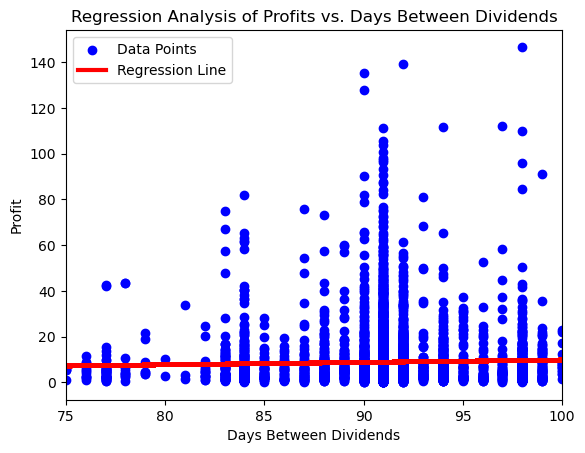

In [17]:
#REGRESSION DCS NEW

import statsmodels.api as sm

df = all_data_cleaned
#print(sp_dd_da_merged.head(45))

#list of companies to drop because data is incomplete for the time period applied
lst = ["^IXIC", "^GSPC"]
#lst = ["ESS"]

# Create a boolean mask where True indicates rows to keep
mask = ~df['symbol'].isin(lst)

# Apply the mask to the DataFrame to keep only the rows that do not match the list
df = df[mask]

# Combine the pairs of stocks into a list
stocks = df['symbol'].unique()

#sp_dd_da_merged_lst_2_1.rename(columns = {"date": "halfway_date_x"})
df = df.rename(columns = {"close_adjusted": "price"})
#print(df)

df['date'] = pd.to_datetime(df['date'])  

from sklearn.linear_model import LinearRegression

# Assuming your DataFrame is named 'df' with columns: 'date', 'price', 'dividend', 'symbol'
# Sort DataFrame by symbol and date if it's not already sorted
df = df.sort_values(['symbol', 'date'])

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['Symbol', 'Days Between Dividends', 'Buy Day', 'Sell Day', 'Profit'])

# Step 1: Identify ex-dividend dates for each symbol
ex_dividend_dates = df[df['dividend'].notnull()].groupby('symbol')['date']

# Step 2-4: Find the best buy and sell days for each pair of dividend dates
for symbol, ex_div_dates in ex_dividend_dates:
    ex_div_dates = ex_div_dates.values
    for i in range(len(ex_div_dates) - 1):
        ex_div_date_1 = ex_div_dates[i]
        ex_div_date_2 = ex_div_dates[i + 1]

        # Filter data for the symbol and dates between ex-dividend dates
        symbol_data = df[df['symbol'] == symbol]
        between_ex_div_dates = symbol_data[(symbol_data['date'] > ex_div_date_1) & (symbol_data['date'] < ex_div_date_2)]

        # Check if there are valid buy dates
        if not between_ex_div_dates.empty:
            # Find the best buy day
            buy_day = between_ex_div_dates.loc[between_ex_div_dates['price'].idxmin()]['date']

            # Find the best sell day
            sell_day = between_ex_div_dates.loc[between_ex_div_dates['price'].idxmax()]['date']

            # Calculate profit
            buy_price = between_ex_div_dates.loc[between_ex_div_dates['date'] == buy_day]['price'].values[0]
            sell_price = between_ex_div_dates.loc[between_ex_div_dates['date'] == sell_day]['price'].values[0]
            profit = sell_price - buy_price

            # Append results to the DataFrame
            results = results.append({'Symbol': symbol,
                                      'Days Between Dividends': (ex_div_date_2 - ex_div_date_1).astype('timedelta64[D]').astype(int),
                                      'Buy Day': buy_day,
                                      'Sell Day': sell_day,
                                      'Profit': profit},
                                     ignore_index=True)

# Step 5: Perform regression analysis
X = results['Days Between Dividends'].values.reshape(-1, 1)
y = results['Profit'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Plot actual data points
plt.scatter(X, y, color='blue', label='Data Points')

# Plot regression line
plt.plot(X, reg.predict(X), color='red', linewidth=3, label='Regression Line')

# Add labels and legend
plt.title('Regression Analysis of Profits vs. Days Between Dividends')
plt.xlabel('Days Between Dividends')
plt.ylabel('Profit')
plt.legend()
plt.xlim(75,100)
# Show plot
plt.show()



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Step 5: Perform regression analysis
X = results['Days Between Dividends'].values.reshape(-1, 1)
y = results['Profit'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Plot actual data points
plt.scatter(X, y, color='blue', label='Data Points')

# Plot regression line
plt.plot(X, reg.predict(X), color='red', linewidth=3, label='Regression Line')

# Add labels and legend
plt.title('Regression Analysis of Profits vs. Days Between Dividends')
plt.xlabel('Days Between Dividends')
plt.ylabel('Profit')
plt.legend()

# Show plot
plt.show()

# Regression summary
print("Regression Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)
print("R-squared:", r2_score(y, reg.predict(X)))

In [203]:
# SP500 AND NASDAQ: Performance Analysis

# SP500

sp500 = all_data_cleaned[all_data_cleaned["symbol"] == "^GSPC"]

sp500['date'] = pd.to_datetime(sp500['date'])

sp500 = sp500.groupby(sp500['date'].dt.year).agg(close_adjusted = ("close_adjusted", "sum")).reset_index()

sp500_year = sp500

tax = []
for i in sp500['close_adjusted']:
    if i == sp500['close_adjusted'][0]:
        tax.append(i)
    else:
        tax.append(i * (1 - tax_rate_bh))
tax_df = pd.DataFrame(tax)

sp500 = pd.merge(sp500,tax_df, how = "inner", left_index = True, right_index = True)
    
sp500 = sp500.rename(columns = {sp500.columns[2]: "diff_inc_tax"}, inplace = False)

sp500["normalized_sp500"] = sp500["diff_inc_tax"] / sp500.iloc[0]["diff_inc_tax"] * 100

# NASDAQ

nasdaq = all_data_cleaned[all_data_cleaned["symbol"] == "^IXIC"]

nasdaq['date'] = pd.to_datetime(nasdaq['date'])

nasdaq = nasdaq.groupby(nasdaq['date'].dt.year).agg(close_adjusted = ("close_adjusted", "sum")).reset_index()

tax = []
for i in nasdaq['close_adjusted']:
    if i == nasdaq['close_adjusted'][0]:
        tax.append(i)
    else:
        tax.append(i * (1 - tax_rate_bh))
tax_df = pd.DataFrame(tax)

nasdaq = pd.merge(nasdaq,tax_df, how = "inner", left_index = True, right_index = True)
    
nasdaq = nasdaq.rename(columns = {nasdaq.columns[2]: "diff_inc_tax"}, inplace = False)

nasdaq["normalized_nasdaq"] = nasdaq["diff_inc_tax"] / nasdaq.iloc[0]["diff_inc_tax"] * 100

sp500 = sp500["diff_inc_tax"]
sp500_perf = pd.DataFrame(sp500)
sp500_perf = sp500_perf.rename(columns = {"diff_inc_tax": "sp500"})

nasdaq = nasdaq["diff_inc_tax"]
nasdaq_perf = pd.DataFrame(nasdaq)
nasdaq_perf = nasdaq_perf.rename(columns={"diff_inc_tax": "nasdaq"})

print(sp500_perf)
print(nasdaq_perf)


            sp500
0   220977.230286
1   158657.155427
2   194002.489524
3   208602.631423
4   171770.706563
5   145273.510958
6   141077.657216
7   165255.722820
8   176448.655427
9   190776.946682
10  215048.496541
11  179028.971244
12  138566.460060
13  166617.359303
14  185278.088389
15  200006.353152
16  240257.657180
17  282289.932205
18  301245.661064
19  306154.228748
20  356536.539263
21  399793.860806
22  425816.168560
23  472188.167275
24  624598.044360
25  596661.776963
26  621140.768721
          nasdaq
0   3.717780e+05
1   2.623436e+05
2   3.987458e+05
3   5.530217e+05
4   2.927138e+05
5   2.250472e+05
6   2.407499e+05
7   2.903506e+05
8   3.068361e+05
9   3.295072e+05
10  3.753732e+05
11  3.172056e+05
12  2.697215e+05
13  3.434604e+05
14  3.913347e+05
15  4.300060e+05
16  5.175953e+05
17  6.394651e+05
18  7.228421e+05
19  7.290158e+05
20  9.077348e+05
21  1.081071e+06
22  1.160529e+06
23  1.496969e+06
24  2.100562e+06
25  1.780640e+06
26  1.880739e+06


C:\Users\jonat\AppData\Local\Temp\ipykernel_12952\3775396320.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['date'] = pd.to_datetime(sp500['date'])
C:\Users\jonat\AppData\Local\Temp\ipykernel_12952\3775396320.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasdaq['date'] = pd.to_datetime(nasdaq['date'])
